Waveform optimisation for WDM carrier function

The idea:
We have a filter in the Tx and Rx. So we can optimise spectral form of it. It has to have band limit. Moreover, in t-domain it has to decay fast.

In [10]:
import os
import numpy as np
import scipy as sp
import tensorflow as tf
import commpy

import matplotlib
import matplotlib.pyplot as plt

import signal_generation as sg
import waveform_optimiser as wf
import channel_model as ch

from tensorflow._api.v2.signal import fft, fftshift, ifft, ifftshift
from tensorflow import cast
# from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint
from importlib import reload
from datetime import datetime

from tensorflow import nn

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


2022-08-12 11:41:35.402872: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-12 11:41:35.466570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 11:41:35.466870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 Laptop GPU computeCapability: 8.6
coreClock: 1.56GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-08-12 11:41:35.466884: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-12 11:41:35.468046: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-12 11:41:35.468097: I tensorflow/stream_ex

In [3]:
reload(sg)
reload(wf)
reload(ch)

<module 'channel_model' from '/home/esf0/PycharmProjects/nn_essential/channel_model.py'>

Optimisation

In [4]:
wdm = ch.create_wdm_parameters(n_channels=1, p_ave_dbm=4, n_symbols=2 ** 16, m_order=16, roll_off=0.1, upsampling=16,
                               downsampling_rate=1, symb_freq=34e9, channel_spacing=75e9, n_polarisations=2)

channel = ch.create_channel_parameters(n_spans=24,
                                       z_span=80,
                                       alpha_db=0.2,
                                       gamma=1.2,
                                       noise_figure_db=4.5,
                                       dispersion_parameter=16.8,
                                       dz=1)

# create points which we will use

p_ave_x_dbm = wdm['p_ave_dbm']  # dBm
p_ave_x = (10 ** (p_ave_x_dbm / 10)) / 1000 / 2
modem_x = commpy.QAMModem(wdm['m_order'])
n_bits_x = int(modem_x.num_bits_symbol * wdm['n_symbols'])
bits_x = np.random.randint(0, 2, n_bits_x, int)  # Random bit stream
gray_x = ch.binarytoGray(bits_x, modem_x.num_bits_symbol)  # after gray code

points_x = modem_x.modulate(gray_x) / np.sqrt(modem_x.Es)  # Modulated baud points sQ = mod1.modulate(sB)/np.sqrt(mod1.Es)
points_x = points_x * np.sqrt(p_ave_x)

p_ave_y_dbm = wdm['p_ave_dbm']  # dBm
p_ave_y = (10 ** (p_ave_y_dbm / 10)) / 1000 / 2
modem_y = commpy.QAMModem(wdm['m_order'])
n_bits_y = int(modem_y.num_bits_symbol * wdm['n_symbols'])
bits_y = np.random.randint(0, 2, n_bits_y, int)  # Random bit stream
gray_y = ch.binarytoGray(bits_y, modem_y.num_bits_symbol)  # after gray code

points_y = modem_y.modulate(gray_y) / np.sqrt(modem_y.Es)  # Modulated baud points sQ = mod1.modulate(sB)/np.sqrt(mod1.Es)
points_y = points_y * np.sqrt(p_ave_y)

# create RRC filter as first approximation

n_t = wdm['upsampling'] * wdm['n_symbols']
ft_filter_values = fftshift(fft(ch.rrcosfilter_our(n_t, wdm['roll_off'], 1 / wdm['symb_freq'], wdm['sample_freq'])))
ft_filter_values = cast(ft_filter_values, tf.complex128)

2022-08-12 11:50:07.769711: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10


In [9]:
test_result = ch.full_line_model_optimise(channel, wdm, points_x, points_y, ft_filter_values, ft_filter_values, return_type='all')
# print(test_result)

BER (x / y): (0.01932525634765625, 5066) (0.019687652587890625, 5161)
Q^2-factor (x / y): 2.0678884612497606 2.0602431136899697
EVM (x / y): 0.7034268609588675 0.7082353924992527


In [6]:

# p_x_orig = points_x / np.sqrt(p_ave_x) * np.sqrt(modem_x.Es)
# p_y_orig = points_y / np.sqrt(p_ave_y) * np.sqrt(modem_y.Es)

p_x_orig = points_x * np.sqrt(modem_x.Es / p_ave_x)
p_y_orig = points_y * np.sqrt(modem_y.Es / p_ave_y)

print(sg.get_ber_by_points(p_x_orig, test_result['points_x_found'], '16qam'))
print(sg.get_ber_by_points(p_y_orig, test_result['points_y_found'], '16qam'))


(0.017486572265625, 2292)
(0.01651763916015625, 2165)


In [13]:
modem_test = commpy.QAMModem(16)
print(modem_test.Es, np.sqrt(modem_test.Es))
points_test = modem_test.modulate(ch.binarytoGray(np.random.randint(0, 2, int(modem_x.num_bits_symbol * 2 ** 18), int), modem_x.num_bits_symbol))
print(np.mean(np.power(np.absolute(points_test), 2)))

points_test[:15]

constellation = sg.get_constellation('16qam')
print(sg.get_average_power(constellation), sg.get_sq_of_average_power(constellation))


10.0 3.1622776601683795
10.01495361328125
10.0 3.1622776601683795


In [39]:
print(np.mean(points_x - test_result['points_orig_x']))
print(np.mean(points_y - test_result['points_orig_y']))
# print(sg.get_ber_by_points_ultimate(points_x, test_result['points_x_found'], '16qam'))
# print(sg.get_ber_by_points_ultimate(points_y, test_result['points_y_found'], '16qam'))
# # print(np.shape(points_x))
# # print(np.shape(test_result['points_x_shifted']))
# print(ch.nonlinear_shift(test_result['points_x'], points_x))
# print(ch.nonlinear_shift(test_result['points_y'], points_y))

# ind = range(0, 30000)
# scale_init = sg.get_scale_coef(points_y, '16qam')
# # print(points_y[ind] * scale_init)
# print(points_y[ind] / np.sqrt(p_ave_y) / np.sqrt(modem_y.Es) * 10)
# print(test_result['points_y_found'][ind])
#
# # p1 = points_y[ind] / np.sqrt(p_ave_y) / np.sqrt(modem_y.Es) * 10
# # p2 = test_result['points_y_found'][ind]
#
# p1 = points_x[ind] / np.sqrt(p_ave_x) / np.sqrt(modem_x.Es) * 10
# p2 = test_result['points_x_found'][ind]
#
# print(sg.get_ber_by_points(p1, p2, '16qam'))

0j
0j


In [ ]:
    # print("BER (x / y):",
    #       sg.get_ber_by_points_ultimate(points_orig_x, points_x_shifted, mod_type),
    #       sg.get_ber_by_points_ultimate(points_orig_y, points_y_shifted, mod_type))

In [27]:
print(np.mean(np.power(np.absolute(modem_y.modulate(gray_y) / np.sqrt(modem_y.Es)), 2)))

1.0062744140625002


4 0.0012559432157547902
4 0.0012559432157547902
p: 0.0012592087895050585 0.001255559932489639
p_ave_calc 0.0012592087895050585
4.011277421435696
0.0012559432157547902
4.0


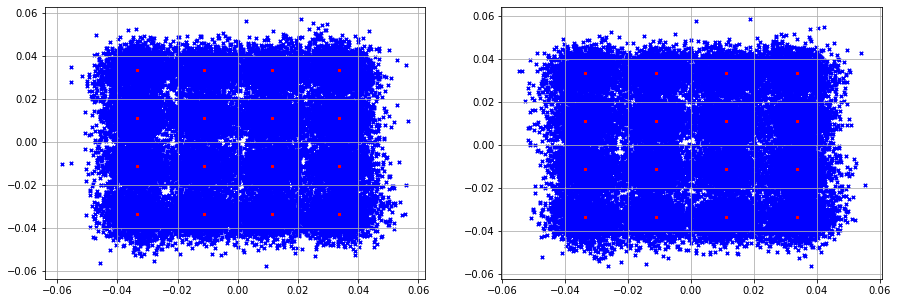

In [14]:
points_x_shifted = test_result['points_x_shifted']
points_y_shifted = test_result['points_y_shifted']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(points_x_shifted.real, points_x_shifted.imag, s=12, c='b', marker='x')
axs[0].scatter(points_x.real, points_x.imag, s=6, c='r', marker='.')
axs[0].grid(True)

axs[1].scatter(points_y_shifted.real, points_y_shifted.imag, s=12, c='b', marker='x')
axs[1].scatter(points_y.real, points_y.imag, s=6, c='r', marker='.')
axs[1].grid(True)

In [132]:
reload(sg)
reload(wf)
reload(ch)

<module 'channel_model' from '/home/esf0/PycharmProjects/nn_essential/channel_model.py'>

In [11]:
def compose(x_c):
    # x_c -> x_r
    # make a real valued array of size 2n
    n = len(x_c)
    x_r = np.zeros(2 * n)
    x_r[:n] = np.real(x_c)
    x_r[n:] = np.imag(x_c)

    return x_r


def decompose(x_r):
    # x_r -> x_c
    n = len(x_r) // 2
    x_c = np.zeros(n, dtype=np.complex128)
    x_c = x_r[:n] + 1j * x_r[n:]
    return x_c


def upsample_zero_sides(f, new_size):

    n = len(f)
    zeros = np.zeros(int((new_size - n) / 2), dtype=np.complex128)
    return np.concatenate((zeros, f, zeros))


def spectrum_add_zero_sides(spectrum, new_size):

    n = len(spectrum)
    n_add = int((new_size - n) / 2)
    if n % 2 == 0:
        zeros_left = np.zeros(n_add, dtype=np.complex128)
        zeros_right = np.zeros(n_add, dtype=np.complex128)
    else:
        zeros_left = np.zeros(n_add + 1, dtype=np.complex128)
        zeros_right = np.zeros(n_add, dtype=np.complex128)
    return np.concatenate((zeros_left, spectrum, zeros_right))


def get_spec_limited(spectrum, freq, bandwidth):
    ind = np.where(np.logical_and(freq >= -bandwidth / 2, freq <= bandwidth / 2))
    return spectrum[ind]


def f_minimise(x, args):

    # x - values for optimisation - cutted spectrum with 2n real values

    start_time = datetime.now()

    channel = args[0]
    wdm = args[1]
    points_x = args[2]
    points_y = args[3]
    spectrum_size = args[4]
    return_type = args[5]


    cut_spectrum = decompose(x)
    # for w-space
    spectrum = spectrum_add_zero_sides(cut_spectrum, spectrum_size)
    filter = ifft(ifftshift(spectrum))

    n_t = wdm['upsampling'] * wdm['n_symbols']
    filter_upsampled = upsample_zero_sides(filter, n_t)
    filter_upsampled = tf.cast(filter_upsampled, tf.complex128)

    ft_filter_values = tf.signal.fftshift(tf.signal.fft(filter_upsampled))

    result = ch.full_line_model_optimise(channel, wdm, points_x, points_y, ft_filter_values, ft_filter_values, return_type=return_type)

    end_time = datetime.now()
    time_diff = (end_time - start_time)
    execution_time = time_diff.total_seconds() * 1000
    print("Function evaluation took", execution_time, "ms")

    return result

In [12]:
print(np.max(np.real(ft_filter_values.numpy())), np.max(np.imag(ft_filter_values.numpy())))

16.000001907348633 3.3699864161462756e-06


In [4]:
x_init = np.real(ft_filter_values.numpy())

In [7]:
ft_filter_size = 2 ** 10 # size of optimized spectrum
bandwidth_frac = 1.2


init_filter_to_optimize = ch.rrcosfilter_our(ft_filter_size, wdm['roll_off'], 1. / wdm['symb_freq'], wdm['sample_freq'])
ft_init_filter = tf.signal.fftshift(tf.signal.fft(init_filter_to_optimize))
freq = fftshift(sp.fft.fftfreq(ft_filter_size, d=1. / wdm['sample_freq']))
init_cut_spectrum = get_spec_limited(ft_init_filter.numpy(), freq, wdm['symb_freq'] * bandwidth_frac)
freq_cut = get_spec_limited(freq, freq, wdm['symb_freq'] * bandwidth_frac)
print('Efficient number of points to optimise:', len(init_cut_spectrum))



NameError: name 'get_spec_limited' is not defined

In [59]:
print(int((ft_filter_size - len(init_cut_spectrum)) // 2) * 2 + 281)
print(freq_cut[0], freq_cut[-1])
print(100 % 2)

print(len(spectrum_add_zero_sides(init_cut_spectrum, ft_filter_size)))
print(ft_filter_size)

4095
-18593750000.0 18593750000.0
0
4096
4096


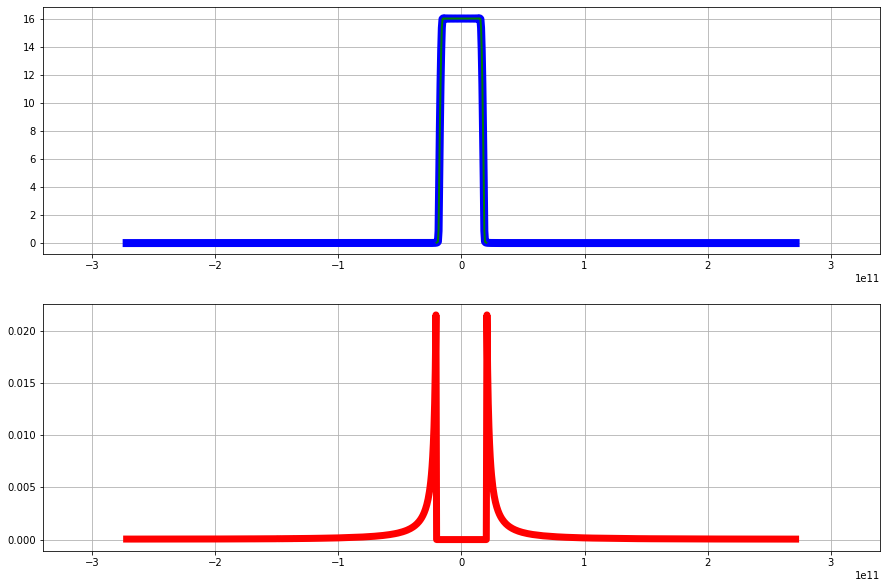

In [15]:
f_coef = 10.0
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(freq, np.absolute(ft_init_filter), linewidth=8, color='blue')
axs[0].plot(freq_cut, np.absolute(init_cut_spectrum), linewidth=2, color='green')
axs[0].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[0].grid(True)

axs[1].plot(freq, np.absolute(spectrum_add_zero_sides(init_cut_spectrum, ft_filter_size) - ft_init_filter), linewidth=7, color='red')
# axs[1].plot(fft_f2, np.absolute(spec2), linewidth=3, color='green')
# axs[1].plot(fft_f2, np.absolute(spec_ups), linewidth=3, color='blue')
# axs[1].set_yscale('log')
# axs[1].set_xlim(-0.6 / t_symb, 0.6 / t_symb)
axs[1].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[1].grid(True)

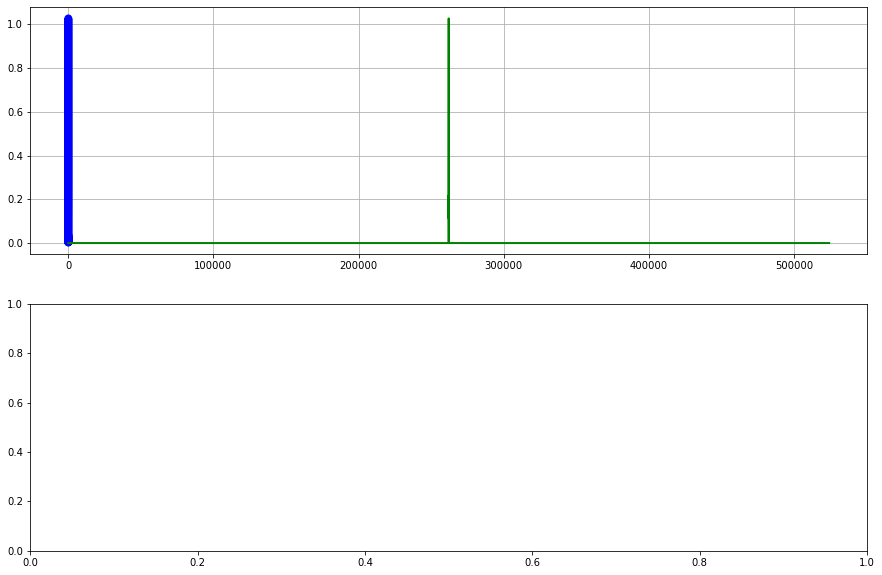

In [23]:
spectrum_draw = spectrum_add_zero_sides(ft_init_filter, ft_filter_size)
filter_draw = ifft(ifftshift(spectrum_draw))

n_t = wdm['upsampling'] * wdm['n_symbols']
filter_upsampled_draw = upsample_zero_sides(filter_draw, n_t)
filter_upsampled_draw = tf.cast(filter_upsampled_draw, tf.complex128)

ft_filter_values_draw = tf.signal.fftshift(tf.signal.fft(filter_upsampled_draw))

f_coef = 10.0
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(np.absolute(init_filter_to_optimize), linewidth=8, color='blue')
axs[0].plot(np.absolute(filter_upsampled_draw), linewidth=2, color='green')
# axs[0].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[0].grid(True)

# axs[1].plot(freq, np.absolute(spectrum_add_zero_sides(init_cut_spectrum, ft_filter_size) - ft_init_filter), linewidth=7, color='red')
# axs[1].plot(fft_f2, np.absolute(spec2), linewidth=3, color='green')
# axs[1].plot(fft_f2, np.absolute(spec_ups), linewidth=3, color='blue')
# axs[1].set_yscale('log')
# axs[1].set_xlim(-0.6 / t_symb, 0.6 / t_symb)
# axs[1].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
# axs[1].grid(True)

In [16]:
def callback(xk, state=None) -> bool:

    print('Callback called back!')

    f_data_save = True
    data_dir = 'data/'

    if state is None:
        # save x to the file
        if f_data_save:
            np.save(data_dir + "data_wf_opt_bfgs.npy", xk)
        # print(xk)
        return False

    # only for method=‘trust-constr’
    print("Number of iterations / function evaluation:", state['nit'], state['nfev'])

    # save x to the file
    save_freq = 1  # frequency of saving
    if f_data_save and state['nit'] % save_freq == 0:
        np.save(data_dir + "data_wf_opt.npy", xk)

    if state['nfev'] >= 10:
        return True
    else:
        return False


def gwo_callback(x, iter_number) -> bool:

    f_data_save = True
    data_dir = 'data/'

    # save x to the file
    save_freq = 1  # frequency of saving
    if f_data_save and iter_number % save_freq == 0:
        np.save(data_dir + "data_wf_opt.npy", x)

In [225]:
# wolf class
class wolf:
    def __init__(self, fitness, x_dim, x_min, x_max, seed, x_init=None, args=None):
        self.rnd = np.random.seed(seed)
        position = np.random.random(x_dim) * (x_max - x_min) + x_min * np.ones(x_dim)
        if x_init is None:
            self.position = position
        else:
            self.position = x_init + position
        self.fitness = fitness(self.position, args=args) # value of fitness function in current position

def grey_wolf_optimisation(fitness, max_iter, n_wolfs, x_dim, x_min, x_max,
                           init_alpha_wolf=None,
                           args=None,
                           callback=None):

    # create n random wolves
    population = [wolf(fitness, x_dim, x_min, x_max, i, args=args, x_init=init_alpha_wolf) for i in range(n_wolfs)]

    population = sorted(population, key = lambda temp: temp.fitness)

    alpha_wolf = population[0]
    beta_wolf = population[1]
    gamma_wolf = population[2]
    # print(alpha_wolf.fitness, beta_wolf.fitness, gamma_wolf.fitness)

    # print([k.fitness for k in population])

    for k in range(max_iter):

        k_iter_print = 1
        # after every k_iter_print iterations
        # print iteration number and best fitness value so far
        if k % k_iter_print == 0 and k > 1:
            print("Iteration ", k ,", best fitness = %.3f" % alpha_wolf.fitness)

        # linearly decreased magic parameter a from 2 to 0
        a = 2 * (1 - k / max_iter)

        for k_wolf in range(n_wolfs):

            a_coef = a * (2 * np.random.random(3) - np.ones(3))
            c_coef = 2 * np.random.random(3)

            x1 = alpha_wolf.position - a_coef[0] * np.absolute(c_coef[0] * alpha_wolf.position - population[k_wolf].position)
            x2 = beta_wolf.position - a_coef[1] * np.absolute(c_coef[1] * beta_wolf.position - population[k_wolf].position)
            x3 = gamma_wolf.position - a_coef[2] * np.absolute(c_coef[2] * gamma_wolf.position - population[k_wolf].position)

            x_new = (x1 + x2 + x3) / 3.

            f_new = fitness(x_new, args)

            if f_new < population[k_wolf].fitness:
                population[k_wolf].fitness = f_new
                population[k_wolf].position = x_new

        population = sorted(population, key = lambda temp: temp.fitness)

        alpha_wolf = population[0]
        beta_wolf = population[1]
        gamma_wolf = population[2]

        if callback is not None:
            callback(alpha_wolf, k)

    return alpha_wolf.position

In [183]:
def f_minimise_test(x, args=None):
    a = np.ones(5) * 10
    # print(a)
    return np.mean(np.absolute(np.power(x, 1) - a))

# res = minimize(f_minimise_test,
#                method='BFGS',
#                x0=np.random.random(5),
#                callback=callback,
#                options={'maxiter': 1, 'disp': True})
#
# print("nit / nfev / njev:", res['nit'], res['nfev'], res['njev'])
# print(res)

# print(grey_wolf_optimisation(f_minimise_test, 20, 1000, 5, -1, 1))
#

In [18]:
data_dir = 'data/'
load_spectrum = True
if load_spectrum:
    spectrum_load = np.load(data_dir + "data_wf_opt_bfgs.npy", allow_pickle=True)

In [17]:
x0 = compose(init_cut_spectrum)
# res = minimize(f_minimise, x0=x0, args=[channel, wdm, points_x, points_y, ft_filter_size],
#                method='CG',
#                options={'maxiter': 30, 'disp': True})
res = minimize(f_minimise,
               method='BFGS',
               x0=x0,
               args=[channel, wdm, points_x, points_y, ft_filter_size, 'evm_x'],
               callback=callback,
               options={'maxiter': 200, 'disp': True})
print(res)

EVM (x / y): 0.4121397337027963 0.41701198196999256
Function evaluation took 5574.223 ms
EVM (x / y): 0.41213973370300766 0.41701198197028355
Function evaluation took 5612.51 ms
EVM (x / y): 0.4121397337030282 0.41701198197043876
Function evaluation took 5631.185 ms
EVM (x / y): 0.4121397337032149 0.41701198197014855
Function evaluation took 5629.843 ms
EVM (x / y): 0.41213973370365586 0.41701198197096445
Function evaluation took 5611.322999999999 ms
EVM (x / y): 0.41213973370147916 0.4170119819696188
Function evaluation took 5616.211 ms
EVM (x / y): 0.4121397337055075 0.41701198197130596
Function evaluation took 5590.606 ms
EVM (x / y): 0.4121397337083635 0.41701198197295347
Function evaluation took 5751.337 ms
EVM (x / y): 0.4121397337012037 0.4170119819697416
Function evaluation took 5614.901 ms
EVM (x / y): 0.41213973371363744 0.41701198198121997
Function evaluation took 5645.721 ms
EVM (x / y): 0.41213973369445 0.41701198196319217
Function evaluation took 5569.085 ms
EVM (x / y): 

KeyboardInterrupt: 

In [26]:
print(res['x'])

[ 7.72295142e-01  1.09248280e+01 -1.51026618e+01  1.50870518e+01
 -1.46382300e+01  1.51736506e+01 -1.44003594e+01  1.50002756e+01
 -1.50660541e+01  1.08724975e+01  7.65929575e-01 -1.86974000e-01
 -2.01274796e-01 -1.42672198e-01 -1.00842856e-01 -1.20131332e-02
 -7.26942893e-03  3.66235889e-02  4.70980665e-02  7.24640146e-02
  2.22786381e-01  1.69711638e-01]


In [226]:
x0 = compose(init_cut_spectrum)
x_found = grey_wolf_optimisation(f_minimise, 100, 100, len(x0), -1, 1,
                                 init_alpha_wolf=x0,
                                 args=[channel, wdm, points_x, points_y, ft_filter_size, 'evm_x'],
                                 callback=gwo_callback)

EVM (x / y): 0.525555173806427 0.5245448213414189
Function evaluation took 6154.971 ms
EVM (x / y): 0.5276271151907931 0.5247314005030822
Function evaluation took 6101.7080000000005 ms
EVM (x / y): 0.5183469280358348 0.5175654439135912
Function evaluation took 6121.9039999999995 ms
EVM (x / y): 0.5201320665380007 0.5207493428694535
Function evaluation took 6148.343 ms
EVM (x / y): 0.5262213578663878 0.5254914830917974
Function evaluation took 6192.532 ms
EVM (x / y): 0.5246270773029111 0.5211648646874113
Function evaluation took 6215.1269999999995 ms
EVM (x / y): 0.518599369432392 0.5214258367029141
Function evaluation took 6186.041 ms
EVM (x / y): 0.5256030634119534 0.5258261238516216
Function evaluation took 6170.558 ms
EVM (x / y): 0.5218113773558596 0.5236253473056309
Function evaluation took 6156.809 ms
EVM (x / y): 0.520513796467052 0.5195458245394173
Function evaluation took 6165.245 ms
EVM (x / y): 0.5210355875824778 0.5224460629364718
Function evaluation took 6087.033 ms
EVM (

KeyboardInterrupt: 

In [217]:
print(f_minimise(x0, [channel, wdm, points_x, points_y, ft_filter_size, 'evm_x']))
print(f_minimise(x_found, [channel, wdm, points_x, points_y, ft_filter_size, 'evm_x']))

EVM (x / y): 0.41362049768965437 0.41268381106008184
Function evaluation took 6113.034 ms
0.41268381106008184
EVM (x / y): 0.46148402281479567 0.4602449003487018
Function evaluation took 6138.083 ms
0.4602449003487018


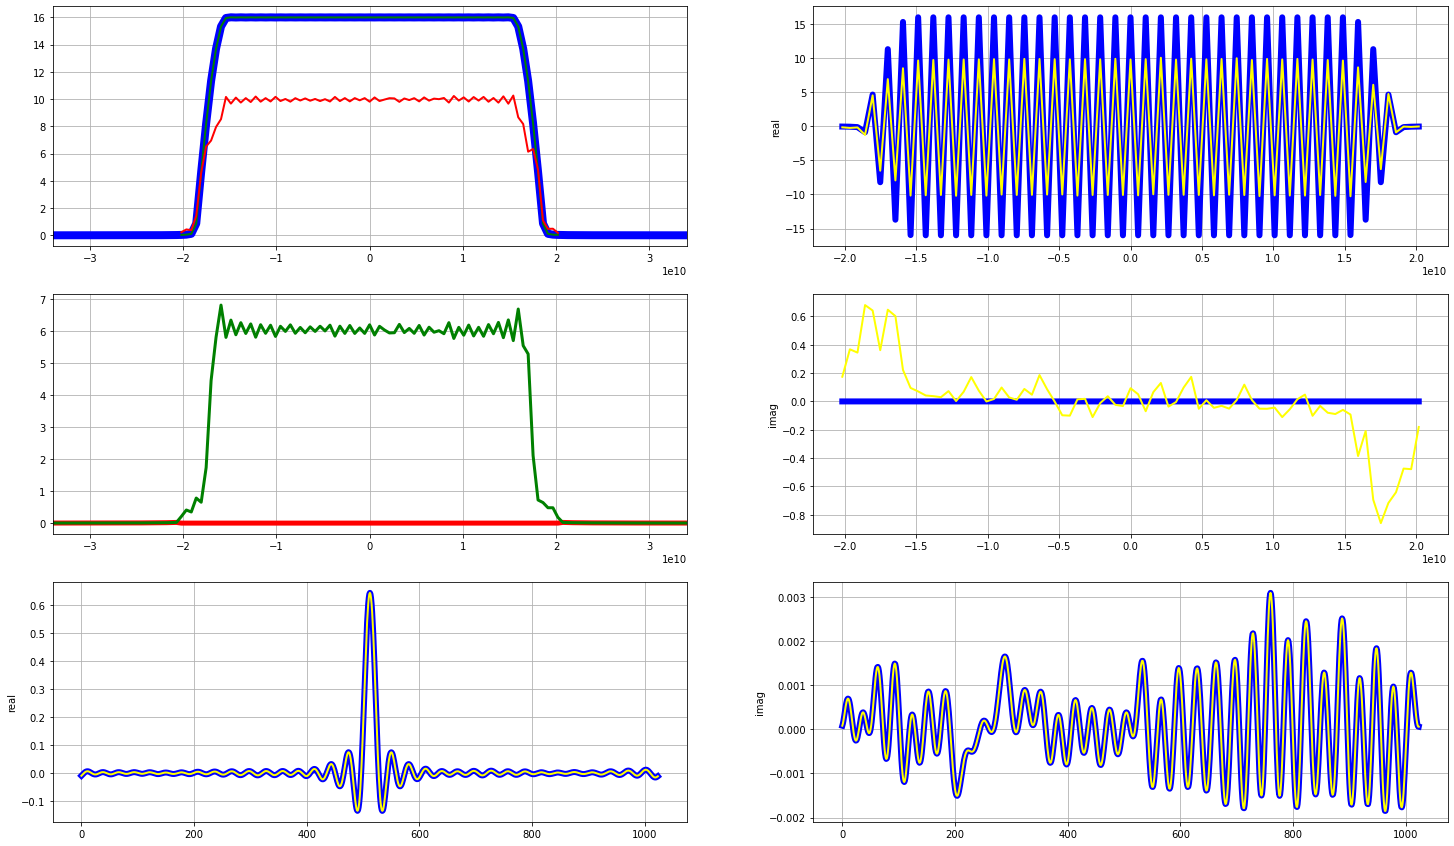

In [36]:
# result_cut_spectrum = decompose(res['x'])
result_cut_spectrum = decompose(spectrum_load)
# for w-space
result_spectrum = spectrum_add_zero_sides(result_cut_spectrum, ft_filter_size)
result_filter = ifft(ifftshift(result_spectrum))

f_coef = 1.0
fig, axs = plt.subplots(3, 2, figsize=(25, 15))
axs[0][0].plot(freq, np.absolute(ft_init_filter), linewidth=8, color='blue')
axs[0][0].plot(freq_cut, np.absolute(init_cut_spectrum), linewidth=2, color='green')
axs[0][0].plot(freq_cut, np.absolute(result_cut_spectrum), linewidth=2, color='red')
axs[0][0].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[0][0].grid(True)

axs[1][0].plot(freq, np.absolute(spectrum_add_zero_sides(init_cut_spectrum, ft_filter_size) - ft_init_filter), linewidth=5, color='red')
axs[1][0].plot(freq, np.absolute(result_spectrum - ft_init_filter), linewidth=3, color='green')
# axs[1].plot(fft_f2, np.absolute(spec2), linewidth=3, color='green')
# axs[1].plot(fft_f2, np.absolute(spec_ups), linewidth=3, color='blue')
# axs[1].set_yscale('log')
# axs[1].set_xlim(-0.6 / t_symb, 0.6 / t_symb)
axs[1][0].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[1][0].grid(True)

axs[0][1].plot(freq_cut, np.real(init_cut_spectrum), linewidth=6, color='blue')
axs[0][1].plot(freq_cut, np.real(result_cut_spectrum), linewidth=2, color='yellow')
# axs[0][1].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[0][1].set_ylabel('real')
axs[0][1].grid(True)

axs[1][1].plot(freq_cut, np.imag(init_cut_spectrum), linewidth=6, color='blue')
axs[1][1].plot(freq_cut, np.imag(result_cut_spectrum), linewidth=2, color='yellow')
# axs[1][1].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[1][1].set_ylabel('imag')
axs[1][1].grid(True)


axs[2][0].plot(np.real(result_filter), linewidth=6, color='blue')
axs[2][0].plot(np.real(result_filter), linewidth=2, color='yellow')
# axs[1][1].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[2][0].set_ylabel('real')
axs[2][0].grid(True)

axs[2][1].plot(np.imag(result_filter), linewidth=6, color='blue')
axs[2][1].plot(np.imag(result_filter), linewidth=2, color='yellow')
# axs[1][1].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[2][1].set_ylabel('imag')
axs[2][1].grid(True)

In [37]:
spectrum_optimised = spectrum_add_zero_sides(decompose(spectrum_load), ft_filter_size)
filter_optimised = ifft(ifftshift(spectrum_optimised))

n_t = wdm['upsampling'] * wdm['n_symbols']
filter_optimised_upsampled = upsample_zero_sides(filter_optimised, n_t)
filter_optimised_upsampled = tf.cast(filter_optimised_upsampled, tf.complex128)

ft_filter_values = tf.signal.fftshift(tf.signal.fft(filter_optimised_upsampled))
result_optimised = ch.full_line_model_optimise(channel, wdm, points_x, points_y, ft_filter_values, ft_filter_values, return_type='all')


ft_filter_values = tf.signal.fftshift(tf.signal.fft(ch.rrcosfilter_our(n_t, wdm['roll_off'], 1 / wdm['symb_freq'], wdm['sample_freq'])))
ft_filter_values = tf.cast(ft_filter_values * 0.01, tf.complex128)
result_not_optimised = ch.full_line_model_optimise(channel, wdm, points_x, points_y, ft_filter_values, ft_filter_values, return_type='all')


EVM (x / y): 0.2068082305706528 0.20524067099984009
EVM (x / y): 4.0672718151855515e-05 4.1148729312959464e-05


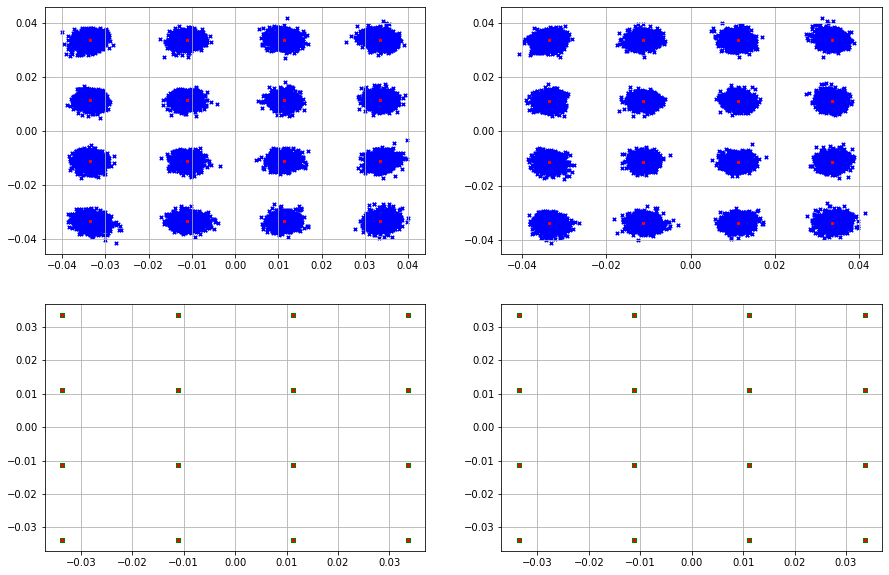

In [38]:
points_x_shifted = result_optimised['points_x_shifted']
points_y_shifted = result_optimised['points_y_shifted']
points_x_shifted_no = result_not_optimised['points_x_shifted']
points_y_shifted_no = result_not_optimised['points_y_shifted']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].scatter(points_x_shifted.real, points_x_shifted.imag, s=12, c='b', marker='x')
axs[0][0].scatter(points_x.real, points_x.imag, s=6, c='r', marker='.')
axs[0][0].grid(True)

axs[0][1].scatter(points_y_shifted.real, points_y_shifted.imag, s=12, c='b', marker='x')
axs[0][1].scatter(points_y.real, points_y.imag, s=6, c='r', marker='.')
axs[0][1].grid(True)

axs[1][0].scatter(points_x_shifted_no.real, points_x_shifted_no.imag, s=12, c='green', marker='x')
axs[1][0].scatter(points_x.real, points_x.imag, s=6, c='r', marker='.')
axs[1][0].grid(True)

axs[1][1].scatter(points_y_shifted_no.real, points_y_shifted_no.imag, s=12, c='green', marker='x')
axs[1][1].scatter(points_y.real, points_y.imag, s=6, c='r', marker='.')
axs[1][1].grid(True)

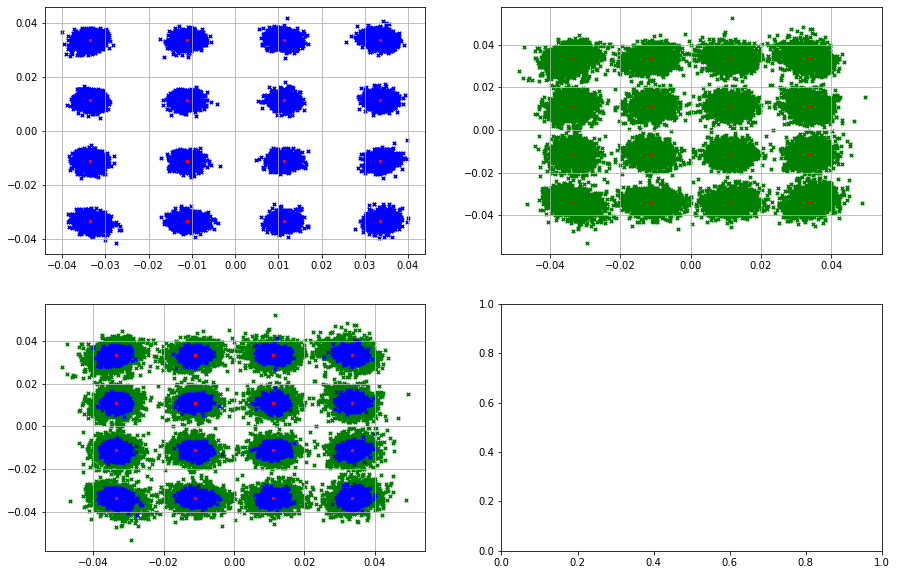

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].scatter(points_x_shifted.real, points_x_shifted.imag, s=12, c='b', marker='x')
axs[0][0].scatter(points_x.real, points_x.imag, s=6, c='r', marker='.')
axs[0][0].grid(True)

axs[0][1].scatter(points_x_shifted_no.real, points_x_shifted_no.imag, s=12, c='green', marker='x')
axs[0][1].scatter(points_x.real, points_x.imag, s=6, c='r', marker='.')
axs[0][1].grid(True)

axs[1][0].scatter(points_x_shifted_no.real, points_x_shifted_no.imag, s=12, c='green', marker='x')
axs[1][0].scatter(points_x_shifted.real, points_x_shifted.imag, s=12, c='b', marker='x')
axs[1][0].scatter(points_x.real, points_x.imag, s=6, c='r', marker='.')
axs[1][0].grid(True)

# axs[1][1].scatter(points_y_shifted_no.real, points_y_shifted_no.imag, s=12, c='green', marker='x')
# axs[1][1].scatter(points_y.real, points_y.imag, s=6, c='r', marker='.')
# axs[1][1].grid(True)

Several waveforms

In [12]:
def chirp_gauss(t, chirp, t0, b, dw=0):

    return np.exp(-0.5 * (1. + 1j * chirp) * np.power(t / t0, 2)) * np.exp(-2.0j * np.pi * dw * t)


def chirped_pulse(t, chirp, t0, b, dw=0):

    return np.exp(-1j * chirp * np.log(np.cosh(b + t / t0))) / (b + np.cosh(t / t0)) * np.exp(-2.0j * np.pi * dw * t)


def varying_chirped_pulse(t, chirp, t0, b, dw=0):

    return np.exp(-1j * chirp * np.log(np.cosh(b + t / t0))) / np.sqrt(b + np.cosh(t / t0)) * np.exp(-2.0j * np.pi * dw * t)


def get_wdm_arbitrary(t, f, chirp, t0, b, n_channels, dw):

    signal = np.zeros(len(t), dtype=complex)

    for wdm_index in range(n_channels):
        w_channel = -2. * np.pi * dw * (wdm_index - (n_channels - 1) // 2)
        signal += f(t, chirp, t0, b) * np.exp(1.0j * w_channel * t)

    return signal


def get_wdm_rrcos(t, nt_span, roll_off, t_symb, dt, n_channels, dw):

    signal = np.zeros(len(t), dtype=complex)

    for wdm_index in range(n_channels):
        w_channel = -2. * np.pi * dw * (wdm_index - (n_channels - 1) // 2)
        signal += ch.rrcosfilter_our(nt_span, roll_off, t_symb, 1 / dt) * np.exp(1.0j * w_channel * t)

    return signal


def shift_pulse(pulse, t, dw):
    return pulse * np.exp(-2.0j * np.pi * dw * t)


def get_outband_spectrum(f, spectrum, dw, side='left'):

    if side == 'left':
        ind = np.where(f < -dw / 2.)
    elif side == 'right':
        ind = np.where(f > dw / 2.)
    else:
        ind = np.where(abs(f) > dw / 2.)

    spec_new = np.zeros(len(f), dtype=np.complex)
    spec_new[ind] = spectrum[ind]

    # return spec_new
    return np.sum(np.power(np.absolute(spectrum[ind]), 2)) / np.sum(np.power(np.absolute(spectrum), 2))


def add_side_signal(signal, n_repeat, n_shift, side='both'):
    new_signal = np.copy(signal)
    for k in range(1, n_repeat + 1):
        if side == 'left':
            new_signal += np.roll(signal, -n_shift * k)
        elif side == 'right':
            new_signal += np.roll(signal, n_shift * k)
        else:
            new_signal += np.roll(signal, -n_shift * k)
            new_signal += np.roll(signal, n_shift * k)

    return new_signal




In [13]:
def get_integral(pulse_one, pulse_two):

    return np.sum(pulse_one * pulse_two)

In [14]:
nt_span = 2 ** 14
t_span = 256.0

# symb_freq = 84e9
# ups = 4
# t_symb = 1.0 / symb_freq
t_symb = 1.0
roll_off = 0.1

dt = t_span / nt_span
# dt = 1 / 84e9
t = (np.arange(nt_span) - nt_span / 2.) * dt
w = np.array([(i - nt_span / 2) * (2. * np.pi / t_span) for i in range(nt_span)])
f = w / (2 * np.pi)

print(t_symb / dt)

64.0


In [15]:
rrcos_time = ch.rrcosfilter_our(nt_span, roll_off, t_symb, 1 / dt)
# rrcos_time_s1 = np.roll(rrcos_time, -int(t_symb / dt))
# rrcos_time_s1 = add_side_signal(rrcos_time, 3, int(t_symb / dt), side='both')
rrcos_f = sp.fft.fftshift(sp.fft.fft(rrcos_time))

dw = 75. / 64.
# ft_filter_size = 2 ** 10 # size of optimized spectrum
bandwidth_frac = 1.2


freq = sp.fft.fftshift(sp.fft.fftfreq(nt_span, d=dt))
rrcos_f_cut = get_spec_limited(rrcos_f, freq, dw * bandwidth_frac)
freq_cut = get_spec_limited(freq, freq, dw * bandwidth_frac)
print('Efficient number of points to optimise:', len(rrcos_f_cut))

Efficient number of points to optimise: 361


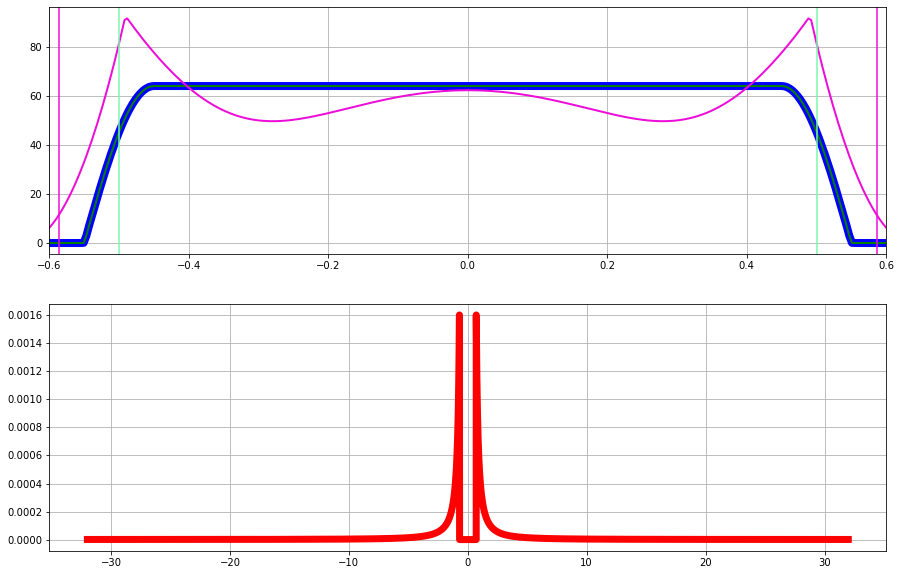

In [18]:
f_coef = 0.6
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(freq, np.absolute(rrcos_f), linewidth=8, color='blue')
axs[0].plot(freq_cut, np.absolute(rrcos_f_cut), linewidth=2, color='green')
axs[0].plot(freq, np.absolute(parabola_spec), linewidth=2, color='xkcd:fuchsia')
axs[0].set_xlim(-f_coef * 1. / t_symb, f_coef * 1 / t_symb)
axs[0].grid(True)

axs[0].axvline(x = -dw / 2, color = 'xkcd:fuchsia', label = '-dw/2')
axs[0].axvline(x = dw / 2, color = 'xkcd:fuchsia', label = 'dw/2')

axs[0].axvline(x = -1. / (2. * t_symb), color = 'xkcd:seafoam green', label = '-1/(2T_s)')
axs[0].axvline(x = 1. / (2. * t_symb), color = 'xkcd:seafoam green', label = '1/(2T_s)')

axs[1].plot(freq, np.absolute(spectrum_add_zero_sides(rrcos_f_cut, nt_span) - rrcos_f), linewidth=7, color='red')
# axs[1].plot(fft_f2, np.absolute(spec2), linewidth=3, color='green')
# axs[1].plot(fft_f2, np.absolute(spec_ups), linewidth=3, color='blue')
# axs[1].set_yscale('log')
# axs[1].set_xlim(-0.6 / t_symb, 0.6 / t_symb)
# axs[1].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[1].grid(True)

In [21]:
# I want to create parabola and two linear sides
# 1st - W
# 2nd



def f_parabola(f, f_1, y_0, y_1):
    values = np.zeros(len(f), dtype=np.complex128)
    ind = np.where(abs(f) <= f_1)
    values[ind] = -(y_0 / np.power(f_1, 2)) * (f[ind] - f_1) * (f[ind] + f_1) + y_1
    return values

def f_parabola_slope(f, f_1, f_3, y_1, y_3, type='right'):

    a = (y_1 - y_3) / np.power(f_1 - f_3, 2)
    # b = -2 * a * f_3
    # c = y_3 + a * f_3 ** 2

    values = np.zeros(len(f), dtype=np.complex128)
    if type == 'right':
        ind = np.where((f > f_1) & (f < f_3))
    elif type == 'left':
        ind = np.where((f < f_1) & (f > f_3))
    else:
        print('error')
        return 0

    values[ind] = a * np.power(f[ind] - f_3, 2) + y_3
    return values

def full_f_spec(f, f_1, f_3, y_0, y_1):

    return f_parabola(f, f_1, y_0, y_1) + f_parabola_slope(f, f_1, f_3, y_1, 0, type='right') + f_parabola_slope(f, -f_1, -f_3, y_1, 0, type='left')
    # return f_parabola(f, f_1, y_0, y_1) + f_parabola_slope(f, f_1, f_3, y_1, 0, type='right')

def get_orth_integral(pulse, n_shift, n_side, dt):

    signal_with_sides = add_side_signal(pulse, n_side, n_shift, side='left')
    signal_with_sides_shift = np.roll(signal_with_sides, -n_shift)

    s_norm = np.sum(np.power(np.absolute(pulse), 2)) * dt
    # pulse_shift = np.roll(pulse, -n_shift)
    sum_shift = np.sum(pulse * np.conjugate(signal_with_sides_shift)) * dt
    return np.absolute(sum_shift / s_norm)


scale_slope = 1.3

f_high = 0.9817/ (2. * t_symb)
f_low = scale_slope * f_high
y_1_phase = np.exp(-1j * 15)
y_0_phase = np.exp(-1j * 3)
# parabola_spec = f_parabola(f, f_high, -5, 16)
parabola_spec = full_f_spec(f, f_1=f_high, f_3=f_low, y_0=-20 * y_0_phase, y_1=16 * y_1_phase) * np.exp(2j * np.pi * t_span / 2. * f)
parabola_spec = parabola_spec * np.sqrt(np.sum(np.power(np.absolute(rrcos_f), 2)) / np.sum(np.power(np.absolute(parabola_spec), 2)))
# parabola_spec = f_parabola_slope(freq, f_1=f_high, f_3=f_low, y_1=16, y_3=0, type='right')
pr_time = sp.fft.ifft(sp.fft.ifftshift(parabola_spec))

print(np.sum(np.power(np.absolute(rrcos_time), 2)))
print(np.sum(np.power(np.absolute(pr_time), 2)))
print(get_orth_integral(rrcos_time, int(t_symb / dt), 0, dt))
print(get_orth_integral(pr_time, int(t_symb / dt), 0, dt))
print(get_outband_spectrum(f, parabola_spec, dw, side='left'))

63.99999353433509
63.99999353433511
9.718992233943365e-08
0.19435749628545243
0.0002826822653958328


/tmp/ipykernel_238059/2885734503.py:51: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spec_new = np.zeros(len(f), dtype=np.complex)


In [83]:
np.arange(30) * 1 - 20 + 0.5

array([-19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5,
       -10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,
        -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,
         7.5,   8.5,   9.5])

In [70]:
def f_minimise_values(x, args):

    y_0 = x[0]
    f_high = x[1]
    f_low = x[2]
    y_0_phase = x[3]
    y_1_phase = x[4]

    # pulse_function = args[0]
    t_span = args[0]
    t = args[1]
    f = args[2]
    dw = args[3]
    n_shift = args[4]

    dt = t[1] - t[0]
    # y_0_phase = 1
    # y_1_phase = 1

    parabola_spec = full_f_spec(f, f_1=f_high, f_3=f_low, y_0=y_0 * np.exp(1j * y_0_phase), y_1=16 * np.exp(1j * y_1_phase)) * np.exp(2j * np.pi * t_span / 2. * f)
    parabola_spec = parabola_spec * np.sqrt(np.sum(np.power(np.absolute(rrcos_f), 2)) / np.sum(np.power(np.absolute(parabola_spec), 2)))
    pr_time = sp.fft.ifft(sp.fft.ifftshift(parabola_spec))

    # value = get_orth_integral(pr_time, n_shift, 0, dt)
    # outband_spectrum_value, orthogonality_value = get_values(chirp, t0, pulse_function, t, f, dw, n_shift)

    max_value = 0
    for k in range(20):
        value = get_orth_integral(pr_time, n_shift, k, dt)
        # value = get_orth_integral(pr_time, int(k * n_shift), 0, dt)
        if value >= max_value:
            max_value = value


    # return value
    return max_value

x0 = np.array([0.1, 0.9 / (2. * t_symb), 1.2 * 0.9 / (2. * t_symb), 0.945, -0.3])
# res = minimize(f_minimise, x0=x0, args=[channel, wdm, points_x, points_y, ft_filter_size],
#                method='CG',
#                options={'maxiter': 30, 'disp': True})

# nlc_energy = NonlinearConstraint(energy_constraint, energy_lb, energy_ub)
f_high_limit = 1 / (2. * t_symb)
f_low_limit = 1.5 * f_high_limit
print(f_high_limit, f_low_limit)
# m_identity =
con = LinearConstraint(np.eye(5), lb=[-100, 0.0, f_high_limit, -np.pi, -np.pi], ub=[100, f_high_limit, f_low_limit, np.pi, np.pi])
res = minimize(f_minimise_values,
               x0=x0,
               # method='Nelder-Mead',
               args=[t_span, t, f, dw, int(t_symb / dt)],
               constraints=[con],
               tol=1e-7,
               options={'maxiter': 1000, 'disp': True})
print(res)

0.5 0.75
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.906248666288097e-05
            Iterations: 18
            Function evaluations: 132
            Gradient evaluations: 18
     fun: 3.906248666288097e-05
     jac: array([-0.00583719,  0.01847008,  0.02225845,  0.00015289, -0.0001529 ])
 message: 'Optimization terminated successfully'
    nfev: 132
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([ 0.00756426,  0.49616428,  0.51428112,  0.9682443 , -0.32324435])


In [76]:
x = res['x']
y_0_optimised = x[0]
f_high_optimised = x[1]
f_low_optimised = x[2]
y_0_phase_opt = x[3] * -15
y_1_phase_opt = x[4] * -15

parabola_spec_opt = full_f_spec(f, f_1=f_high_optimised, f_3=f_low_optimised,
                                y_0=y_0_optimised * np.exp(1j * y_0_phase_opt),
                                y_1=16 * np.exp(1j * y_1_phase_opt)) * np.exp(2j * np.pi * t_span / 2. * f)
parabola_spec_opt = parabola_spec_opt * np.sqrt(np.sum(np.power(np.absolute(rrcos_f), 2)) / np.sum(np.power(np.absolute(parabola_spec_opt), 2)))
pr_time_opt = sp.fft.ifft(sp.fft.ifftshift(parabola_spec_opt))

# print(np.sum(np.power(np.absolute(rrcos_time), 2)))
# print(np.sum(np.power(np.absolute(pr_time_opt), 2)))
# print(get_orth_integral(rrcos_time, int(t_symb / dt), dt))
print(get_orth_integral(pr_time_opt, int(t_symb / dt), 0, dt),
      get_orth_integral(pr_time_opt, int(t_symb / dt), 5, dt),
      get_orth_integral(pr_time_opt, int(t_symb / dt), 10, dt),
      get_orth_integral(pr_time_opt, int(t_symb / dt), 20, dt))
print(get_outband_spectrum(f, parabola_spec_opt, dw, side='left'))
# print(get_outband_spectrum(f, rrcos_f, dw, side='left'))

8.835934004842636e-05 0.0001280073862752928 8.56008172349451e-05 0.0001490415599473906
0.0


/tmp/ipykernel_238059/2885734503.py:51: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spec_new = np.zeros(len(f), dtype=np.complex)


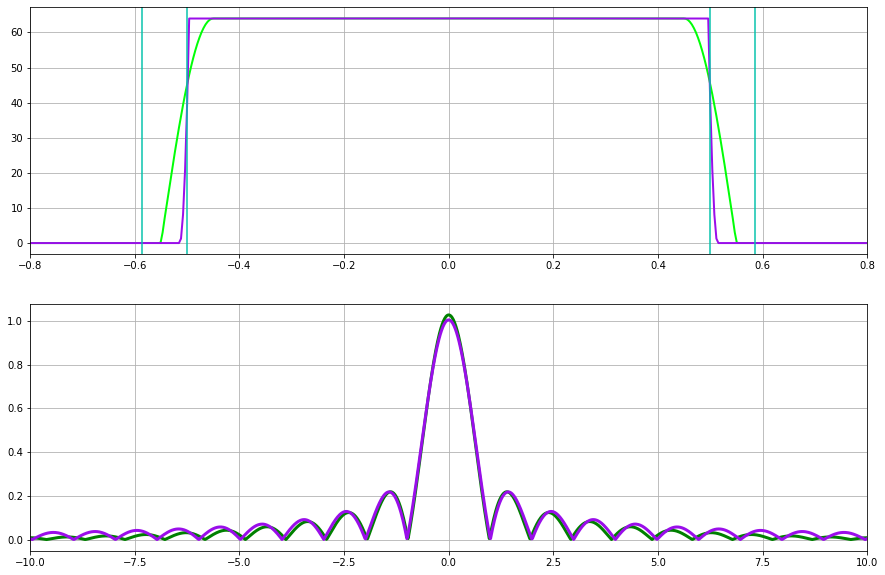

In [77]:
f_coef = 0.8
t_coef = 10
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(freq, np.absolute(rrcos_f), linewidth=2, color='xkcd:bright green')
# axs[0].plot(freq_cut, np.absolute(rrcos_f_cut), linewidth=2, color='xkcd:bright green')
# axs[0].plot(freq, np.absolute(parabola_spec), linewidth=2, color='xkcd:fuchsia')
axs[0].plot(freq, np.absolute(parabola_spec_opt), linewidth=2, color='xkcd:violet')
axs[0].set_xlim(-f_coef * 1. / t_symb, f_coef * 1 / t_symb)
axs[0].grid(True)

axs[0].axvline(x = -dw / 2, color = 'xkcd:turquoise', label = '-dw/2')
axs[0].axvline(x = dw / 2, color = 'xkcd:turquoise', label = 'dw/2')

axs[0].axvline(x = -1. / (2. * t_symb), color = 'xkcd:turquoise', label = '-1/(2T_s)')
axs[0].axvline(x = 1. / (2. * t_symb), color = 'xkcd:turquoise', label = '1/(2T_s)')

axs[1].plot(t, np.absolute(rrcos_time), linewidth=3, color='green')
# axs[1].plot(t, np.absolute(pr_time), linewidth=5, color='xkcd:fuchsia')
axs[1].plot(t, np.absolute(pr_time_opt), linewidth=3, color='xkcd:violet')
# axs[1].plot(t, np.absolute(np.roll(add_side_signal(pr_time_opt, 3, int(t_symb / dt), side='left'), -int(t_symb / dt))), linewidth=3, color='xkcd:green')
axs[1].set_xlim(-t_coef * t_symb, t_coef * t_symb)
axs[1].grid(True)

In [ ]:
Procedure:

spectrum = spectrum_add_zero_sides(cut_spectrum, spectrum_size)
filter = ifft(ifftshift(spectrum))

n_t = wdm['upsampling'] * wdm['n_symbols']
filter_upsampled = upsample_zero_sides(filter, n_t)

ft_filter_values = tf.signal.fftshift(tf.signal.fft(filter_upsampled))

Old code with theoretical functions

In [18]:


def scan_values(chirp_values, t0_values, pulse_function, t, f, dw, n_shift):
    b = 0
    dt = t[1] - t[0]

    outband_spectrum_values = np.ndarray((len(chirp_values), len(t0_values)))
    orthogonality_values = np.ndarray((len(chirp_values), len(t0_values)), dtype=complex)
    orthogonality_values_extended = np.ndarray((len(chirp_values), len(t0_values)), dtype=complex)

    for i_chirp, i_t0 in np.ndindex((len(chirp_values), len(t0_values))):

        # print(chirp_values[i_chirp], t0_values[i_t0])

        pulse = pulse_function(t, chirp_values[i_chirp], t0_values[i_t0], b)
        spectrum = sp.fft.fftshift(sp.fft.fft(pulse))

        outband_spectrum_values[i_chirp][i_t0] = get_outband_spectrum(f, spectrum, dw, side='left')

        signal_with_sides = add_side_signal(pulse, 30, n_shift, side='left')
        sum_shift = np.sum(pulse * np.conjugate(np.roll(pulse, n_shift))) * dt
        s_norm = np.sum(np.power(np.absolute(pulse), 2)) * dt
        # orthogonality_values[i_chirp][i_t0] = np.sum(pulse * signal_with_sides) * dt
        orthogonality_values[i_chirp][i_t0] = np.absolute(sum_shift / s_norm)

        signal_with_sides_shift = np.roll(signal_with_sides, -n_shift)
        sum_shift = np.sum(pulse * np.conjugate(signal_with_sides_shift)) * dt
        orthogonality_values_extended[i_chirp][i_t0] = np.absolute(sum_shift / s_norm)

    return outband_spectrum_values, orthogonality_values, orthogonality_values_extended


def get_values(chirp, t0, pulse_function, t, f, dw, n_shift):

    b = 0
    pulse = pulse_function(t, chirp, t0, b)
    spectrum = sp.fft.fftshift(sp.fft.fft(pulse))

    outband_spectrum_value = get_outband_spectrum(f, spectrum, dw, side='left')
    signal_with_sides = add_side_signal(pulse, 10, n_shift, side='both')
    orthogonality_value = np.sum(cpulse_time * signal_with_sides) * dt

    return outband_spectrum_value, orthogonality_value


def f_minimise_values(x, args):

    chirp = x[0]
    t0 = x[1]
    pulse_function = args[0]
    t = args[1]
    f = args[2]
    dw = args[3]
    n_shift = args[4]

    outband_spectrum_value, orthogonality_value = get_values(chirp, t0, pulse_function, t, f, dw, n_shift)

    return outband_spectrum_value * 100 + np.absolute(1.0 - orthogonality_value)


In [33]:
rrcos_time = ch.rrcosfilter_our(nt_span, roll_off, t_symb, 1 / dt)
# rrcos_time_s1 = np.roll(rrcos_time, -int(t_symb / dt))
rrcos_time_s1 = add_side_signal(rrcos_time, 3, int(t_symb / dt), side='both')
rrcos_f = sp.fft.fftshift(sp.fft.fft(rrcos_time))

dw = 75. / 64.
t0 = 0.2
chirp = 10
b = 0.0
cgauss_time = chirp_gauss(t, chirp, t0, b)
cgauss_time_shift = chirp_gauss(t, chirp, t0, b, dw=dw)
cpulse_time = chirped_pulse(t, chirp, t0, b)
vcpulse_time = varying_chirped_pulse(t, chirp, t0, b)

wdm_rrcos_time = get_wdm_rrcos(t, nt_span, roll_off, t_symb, dt, 3, dw)
wdm_cgauss_time = get_wdm_arbitrary(t, chirp_gauss, chirp, t0, b, 3, dw)
wdm_cpulse_time = get_wdm_arbitrary(t, chirped_pulse, chirp, t0, b, 3, dw)
wdm_vcpulse_time = get_wdm_arbitrary(t, varying_chirped_pulse, chirp, t0, b, 3, dw)

# spectra

cgauss_f = sp.fft.fftshift(sp.fft.fft(cgauss_time))
cgauss_f_shift = sp.fft.fftshift(sp.fft.fft(cgauss_time_shift))
cpulse_f = sp.fft.fftshift(sp.fft.fft(cpulse_time))
vcpulse_f = sp.fft.fftshift(sp.fft.fft(vcpulse_time))

wdm_rrcos_f = sp.fft.fftshift(sp.fft.fft(wdm_rrcos_time))
wdm_cgauss_f = sp.fft.fftshift(sp.fft.fft(wdm_cgauss_time))
wdm_cpulse_f = sp.fft.fftshift(sp.fft.fft(wdm_cpulse_time))
wdm_vcpulse_f = sp.fft.fftshift(sp.fft.fft(wdm_vcpulse_time))

In [20]:
x0 = np.array([3.0, 2.0])
# res = minimize(f_minimise, x0=x0, args=[channel, wdm, points_x, points_y, ft_filter_size],
#                method='CG',
#                options={'maxiter': 30, 'disp': True})

# nlc_energy = NonlinearConstraint(energy_constraint, energy_lb, energy_ub)
con = LinearConstraint([[1, 0], [0, 1]], lb=[-np.inf, 0.1], ub=[np.inf, np.inf])
res = minimize(f_minimise_values,
               x0=x0,
               args=[varying_chirped_pulse, t, f, dw, 10],
               constraints=[con],
               options={'maxiter': 200, 'disp': True})
print(res)

/home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages/scipy/optimize/_constraints.py:386: OptimizeWarning: At least one constraint is unbounded above and below. Such constraints are ignored.
  warn("At least one constraint is unbounded above and below. Such "
/tmp/ipykernel_6163/4074007452.py:13: RuntimeWarning: overflow encountered in cosh
  return np.exp(-1j * chirp * np.log(np.cosh(b + t / t0))) / np.sqrt(b + np.cosh(t / t0)) * np.exp(-2.0j * np.pi * dw * t)
/tmp/ipykernel_6163/4074007452.py:13: RuntimeWarning: invalid value encountered in multiply
  return np.exp(-1j * chirp * np.log(np.cosh(b + t / t0))) / np.sqrt(b + np.cosh(t / t0)) * np.exp(-2.0j * np.pi * dw * t)
/tmp/ipykernel_6163/4074007452.py:13: RuntimeWarning: invalid value encountered in exp
  return np.exp(-1j * chirp * np.log(np.cosh(b + t / t0))) / np.sqrt(b + np.cosh(t / t0)) * np.exp(-2.0j * np.pi * dw * t)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 20.13813126473496
            Iterations: 39
            Function evaluations: 173
            Gradient evaluations: 39
     fun: 20.13813126473496
     jac: array([0.79221869, 3.32085037])
 message: 'Optimization terminated successfully'
    nfev: 173
     nit: 39
    njev: 39
  status: 0
 success: True
       x: array([0.30162177, 0.18016142])


In [22]:
n_chirp_values = 90
chirp_range = 30
# chirp_values = (np.arange(n_chirp_values) - (n_chirp_values - 1) / 2) * chirp_range / (n_chirp_values - 1)
chirp_values = np.arange(n_chirp_values) * chirp_range / (n_chirp_values - 1)

n_t0_values = 50
t0_range = 5
# t0_values = (np.arange(n_t0_values) - (n_t0_values - 1) / 2) * t0_range / (n_t0_values - 1)
t0_values = np.arange(n_t0_values) * t0_range / (n_t0_values - 1) + 3

os_chirp_gauss, or_chirp_gauss, ore_chirp_gauss = scan_values(chirp_values, t0_values, chirp_gauss, t, f, dw, int(t_symb / dt))
os_chirped_pulse, or_chirped_pulse, ore_chirped_pulse = scan_values(chirp_values, t0_values, chirped_pulse, t, f, dw, int(t_symb / dt))
os_vchirped_pulse, or_vchirped_pulse, ore_vchirped_pulse = scan_values(chirp_values, t0_values, varying_chirped_pulse, t, f, dw, int(t_symb / dt))


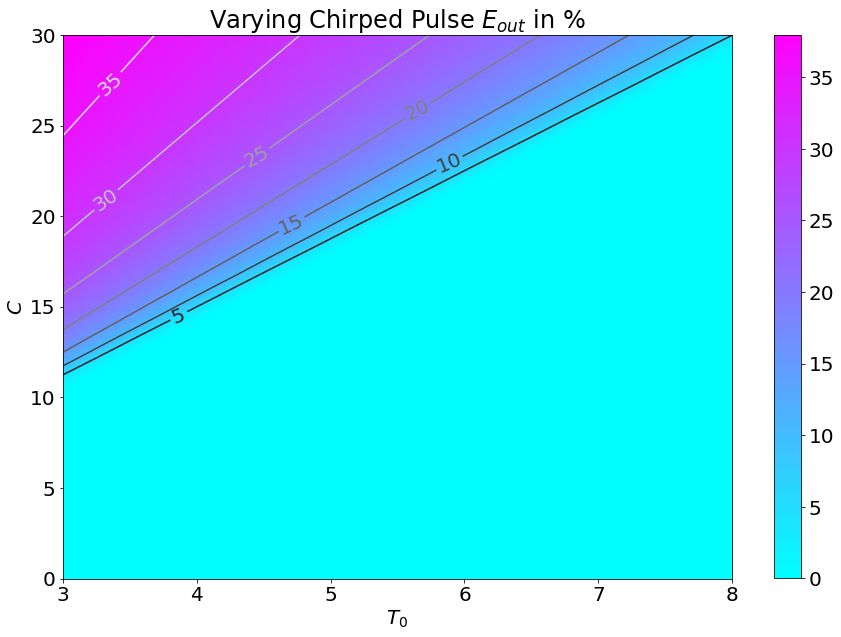

In [23]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
matplotlib.rcParams.update({'font.size': 20})

# draw_type = 'Chirped Gaussian'
# draw_type = 'Chirped Pulse'
draw_type = 'Varying Chirped Pulse'


X, Y = np.meshgrid(t0_values, chirp_values)

if draw_type == 'Chirped Gaussian':
    plot_name = 'chirped_gaussian'
    or_value = or_chirp_gauss
    ore_value = ore_chirp_gauss
    os_value = os_chirp_gauss
elif draw_type == 'Chirped Pulse':
    plot_name = 'chirped_pulse'
    or_value = or_chirped_pulse
    ore_value = ore_chirped_pulse
    os_value = os_chirped_pulse
elif draw_type == 'Varying Chirped Pulse':
    plot_name = 'varying_chirped_pulse'
    or_value = or_vchirped_pulse
    ore_value = ore_vchirped_pulse
    os_value = os_vchirped_pulse

# Z = np.angle(1.0 - or_value)
# Z = np.absolute(1.0 - or_value)
Z = os_value * 100


fig, axs = plt.subplots(1, 1, figsize=(15, 10))
# plt.rcParams["figure.figsize"] = (15,15)

plot = axs.pcolormesh(X, Y, Z, cmap='cool', shading='gouraud')
cset = axs.contour(X, Y, Z, cmap='gray')
plt.clabel(cset, inline=True)

axs.set_title(draw_type + ' ' + r'$E_{out}$' + ' in %')
# axs.set_title(draw_type + ' deviation from orthogonality')
axs.set_xlabel(r'$T_0$')
axs.set_ylabel(r'$C$')
# axs.set_xlim(-3.5, 3.5)

plt.colorbar(plot)
plt.show()

# fig.savefig('../results/' + plot_name + '_outband_spectrum.pdf', format='pdf', bbox_inches='tight')

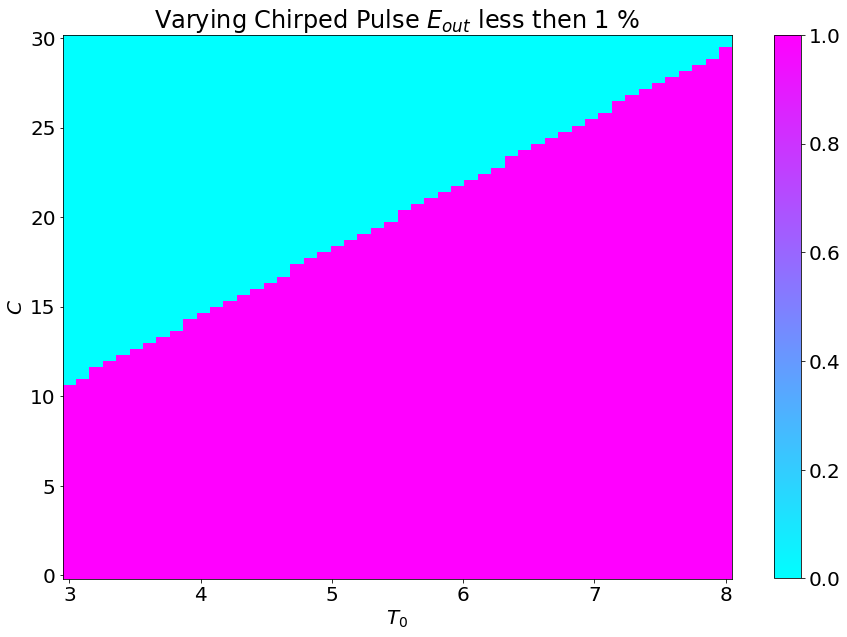

In [304]:
max_value_for_os = 0.01

ind_for_max = np.where(os_value <= max_value_for_os)
ind_for_max_inv = np.where(os_value > max_value_for_os)
os_value_con = os_value.copy()
os_value_con[ind_for_max] = 1.0
os_value_con[ind_for_max_inv] = 0.0
Z = os_value_con

fig, axs = plt.subplots(1, 1, figsize=(15, 10))
# plt.rcParams["figure.figsize"] = (15,15)

plot = axs.pcolormesh(X, Y, Z, cmap='cool')
# cset = axs.contour(X, Y, Z, cmap='gray')
# plt.clabel(cset, inline=True)

axs.set_title(draw_type + ' ' + r'$E_{out}$' + ' less then 1 %')
# axs.set_title(draw_type + ' deviation from orthogonality')
axs.set_xlabel(r'$T_0$')
axs.set_ylabel(r'$C$')
# axs.set_xlim(-3.5, 3.5)

plt.colorbar(plot)
plt.show()

# fig.savefig('../results/' + plot_name + '_outband_spectrum_less_0_01.pdf', format='pdf', bbox_inches='tight')

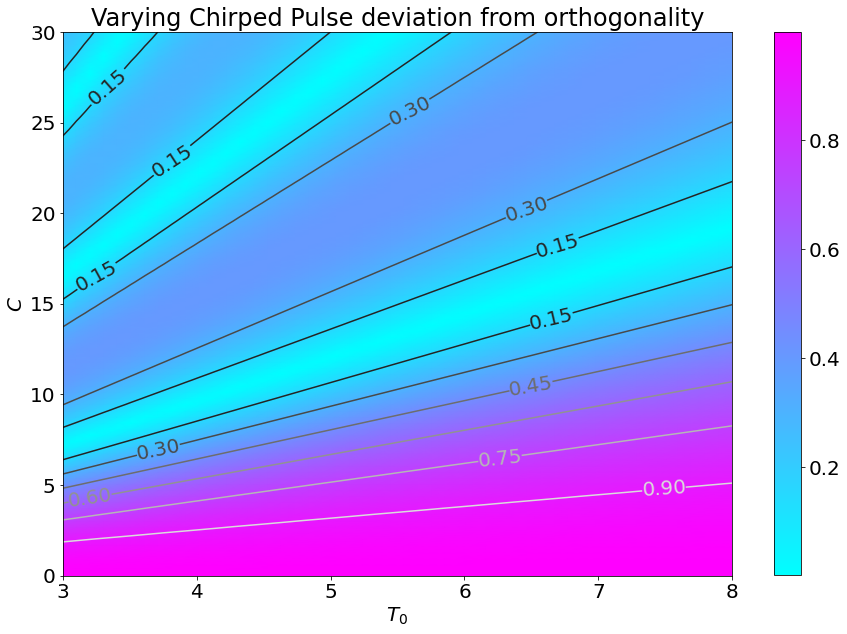

In [303]:
# Z = np.angle(1.0 - or_value)
# Z = np.absolute(1.0 - or_value)
# Z = os_value
Z = np.absolute(or_value)


fig, axs = plt.subplots(1, 1, figsize=(15, 10))
# plt.rcParams["figure.figsize"] = (15,15)

plot = axs.pcolormesh(X, Y, Z, cmap='cool', shading='gouraud')
cset = axs.contour(X, Y, Z, cmap='gray')
plt.clabel(cset, inline=True)

# axs.set_title(draw_type + ' outband spectrum')
axs.set_title(draw_type + ' deviation from orthogonality')
axs.set_xlabel(r'$T_0$')
axs.set_ylabel(r'$C$')
# axs.set_xlim(-3.5, 3.5)

plt.colorbar(plot)
plt.show()

# fig.savefig('../results/' + plot_name + '_deviation_orthogonality.pdf', format='pdf', bbox_inches='tight')


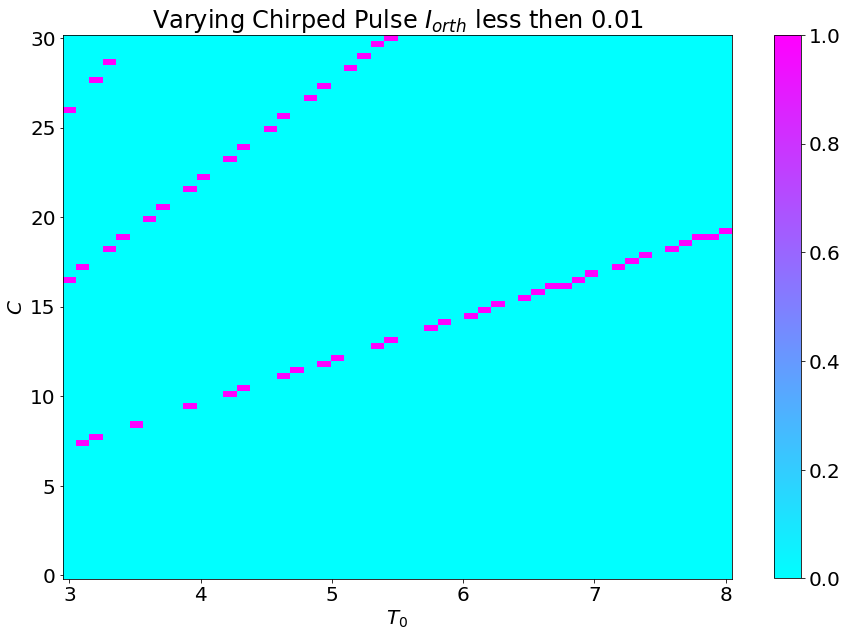

In [291]:
max_value_for_or = 0.01

ind_for_max = np.where(or_value <= max_value_for_or)
ind_for_max_inv = np.where(or_value > max_value_for_or)
or_value_con = np.absolute(or_value).copy()
or_value_con[ind_for_max] = 1.0
or_value_con[ind_for_max_inv] = 0.0
Z = or_value_con

fig, axs = plt.subplots(1, 1, figsize=(15, 10))
# plt.rcParams["figure.figsize"] = (15,15)

# plot = axs.pcolormesh(X, Y, Z, cmap='cool', shading='gouraud')
plot = axs.pcolormesh(X, Y, Z, cmap='cool')
# cset = axs.contour(X, Y, Z, cmap='gray')
# plt.clabel(cset, inline=True)

axs.set_title(draw_type + ' ' + r'$I_{orth}$' + ' less then 0.01')
# axs.set_title(draw_type + ' deviation from orthogonality')
axs.set_xlabel(r'$T_0$')
axs.set_ylabel(r'$C$')
# axs.set_xlim(-3.5, 3.5)

plt.colorbar(plot)
plt.show()

fig.savefig('../results/' + plot_name + '_deviation_orthogonality_less_0_01_other.pdf', format='pdf', bbox_inches='tight')

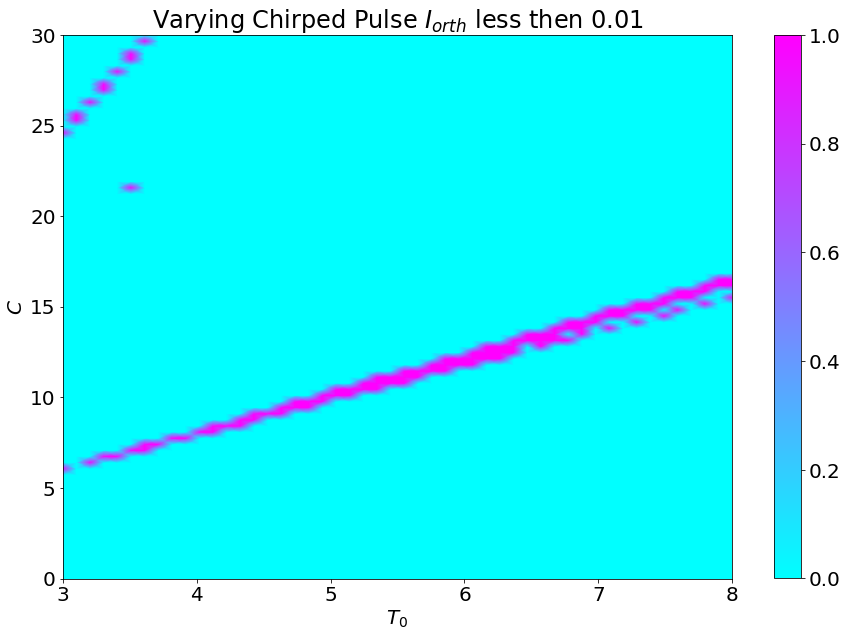

In [286]:
max_value_for_ore = 0.01

ind_for_max = np.where(ore_value <= max_value_for_ore)
ind_for_max_inv = np.where(ore_value > max_value_for_ore)
ore_value_con = np.absolute(ore_value).copy()
ore_value_con[ind_for_max] = 1.0
ore_value_con[ind_for_max_inv] = 0.0
Z = ore_value_con

fig, axs = plt.subplots(1, 1, figsize=(15, 10))
# plt.rcParams["figure.figsize"] = (15,15)

plot = axs.pcolormesh(X, Y, Z, cmap='cool', shading='gouraud')
# cset = axs.contour(X, Y, Z, cmap='gray')
# plt.clabel(cset, inline=True)

axs.set_title(draw_type + ' ' + r'$I_{orth}$' + ' less then 0.01')
# axs.set_title(draw_type + ' deviation from orthogonality')
axs.set_xlabel(r'$T_0$')
axs.set_ylabel(r'$C$')
# axs.set_xlim(-3.5, 3.5)

plt.colorbar(plot)
plt.show()

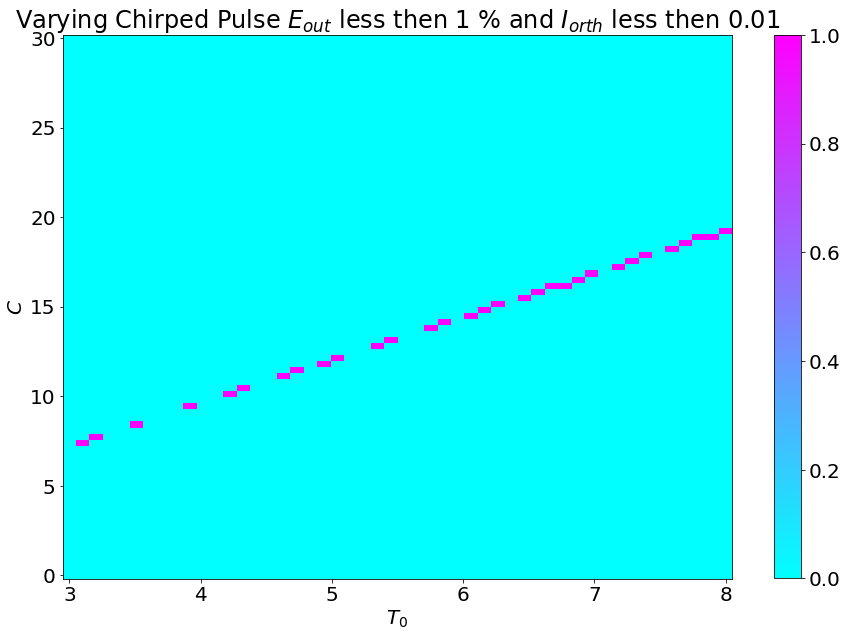

In [307]:
sum_con = os_value_con + or_value_con
ind_for_max = np.where(sum_con >= 1.99)
ind_for_max_inv = np.where(sum_con < 1.99)
sum_value_con = sum_con.copy()
sum_value_con[ind_for_max] = 1.0
sum_value_con[ind_for_max_inv] = 0.0

Z = sum_value_con

fig, axs = plt.subplots(1, 1, figsize=(15, 10))
# plt.rcParams["figure.figsize"] = (15,15)

plot = axs.pcolormesh(X, Y, Z, cmap='cool')
# cset = axs.contour(X, Y, Z, cmap='gray')
# plt.clabel(cset, inline=True)

axs.set_title(draw_type + ' ' + r'$E_{out}$' + ' less then 1 % and ' + r'$I_{orth}$' + ' less then 0.01')
# axs.set_title(draw_type + ' deviation from orthogonality')
axs.set_xlabel(r'$T_0$')
axs.set_ylabel(r'$C$')
# axs.set_xlim(-3.5, 3.5)

plt.colorbar(plot)
plt.show()

# fig.savefig('../results/' + plot_name + '_overlap.pdf', format='pdf', bbox_inches='tight')

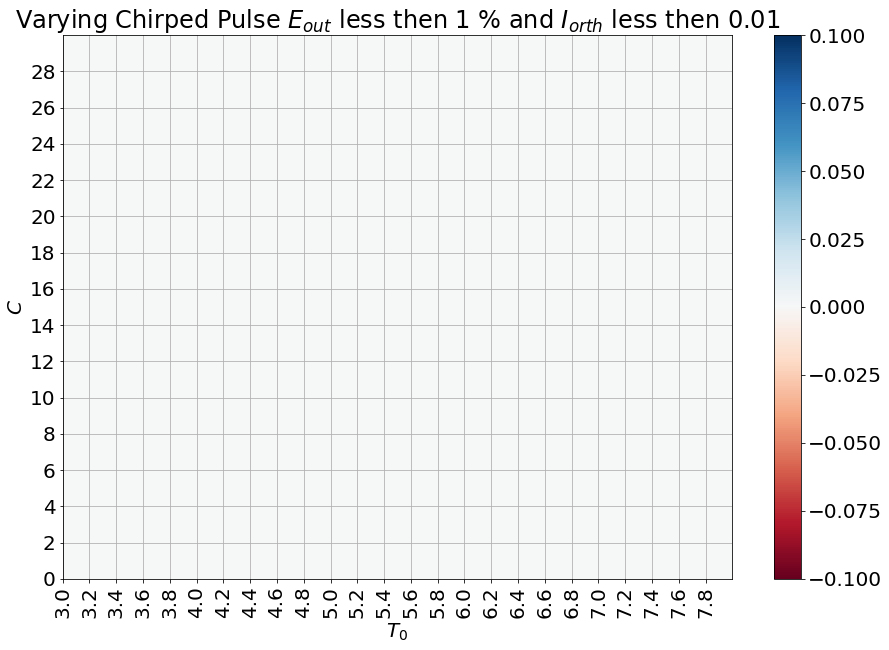

In [282]:
sum_con = os_value_con + ore_value_con + or_value_con
ind_for_max = np.where(sum_con >= 2.99)
ind_for_max_inv = np.where(sum_con < 2.99)
sum_value_con = sum_con.copy()
sum_value_con[ind_for_max] = 1.0
sum_value_con[ind_for_max_inv] = 0.0

Z = sum_value_con

fig, axs = plt.subplots(1, 1, figsize=(15, 10))
# plt.rcParams["figure.figsize"] = (15,15)

plot = axs.pcolormesh(X, Y, Z, cmap='RdBu', shading='gouraud')
# cset = axs.contour(X, Y, Z, cmap='gray')
# plt.clabel(cset, inline=True)

axs.set_title(draw_type + ' ' + r'$E_{out}$' + ' less then 1 % and ' + r'$I_{orth}$' + ' less then 0.01')
# axs.set_title(draw_type + ' deviation from orthogonality')
axs.set_xlabel(r'$T_0$')
axs.set_ylabel(r'$C$')
axs.grid(True)
# axs.set_xlim(-3.5, 3.5)

start, end = axs.get_xlim()
axs.xaxis.set_ticks(np.arange(start, end, 0.2))
axs.set_xticklabels(axs.get_xticks(), rotation = 90)
axs.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

start, end = axs.get_ylim()
axs.yaxis.set_ticks(np.arange(start, end, 2))
# axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

plt.colorbar(plot)
plt.show()

# fig.savefig('../results/' + plot_name + '_overlap_extended.pdf', format='pdf', bbox_inches='tight')


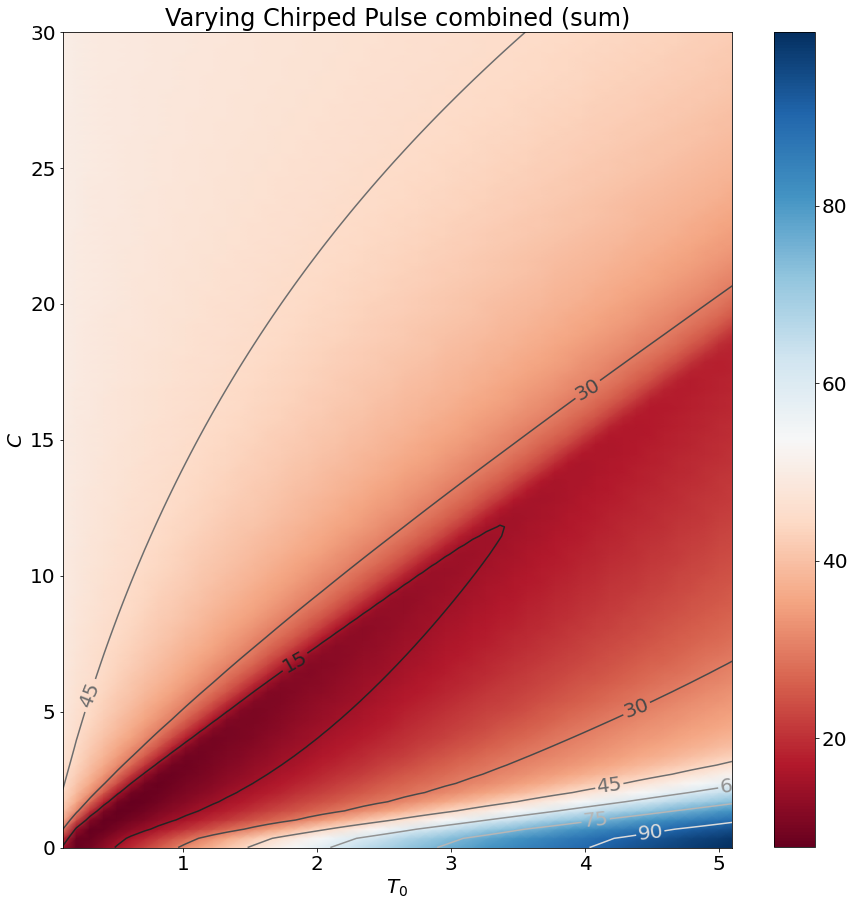

In [99]:
# Z = np.angle(1.0 - or_value)
# Z = np.absolute(1.0 - or_value)
Z = os_value * 100 + np.absolute(1.0 - or_value)


fig, axs = plt.subplots(1, 1, figsize=(15, 15))
# plt.rcParams["figure.figsize"] = (15,15)

plot = axs.pcolormesh(X, Y, Z, cmap='RdBu', shading='gouraud')
cset = axs.contour(X, Y, Z, cmap='gray')
plt.clabel(cset, inline=True)

axs.set_title(draw_type + ' combined (sum)')
# axs.set_title(draw_type + ' deviation from orthogonality')
axs.set_xlabel(r'$T_0$')
axs.set_ylabel(r'$C$')
# axs.set_xlim(-3.5, 3.5)

plt.colorbar(plot)
plt.show()

fig.savefig('../results/' + plot_name + '_combined.pdf', format='pdf', bbox_inches='tight')

In [189]:
def z_func(x, y):
    return (1 - (x ** 2 + y ** 3)) * np.exp(-(x ** 2 + y ** 2) / 2)

x = np.arange(-3.0, 3.0, 0.1)
y = np.arange(-3.0, 3.0, 0.1)

X, Y = np.meshgrid(x, y)
Z = z_func(X, Y)

print(np.shape(Z))

(60, 60)


In [174]:
print(get_outband_spectrum(f, rrcos_f, dw, side='left'))
print(get_outband_spectrum(f, cgauss_f, dw, side='left'))
print(get_outband_spectrum(f, cpulse_f, dw, side='left'))
print(get_outband_spectrum(f, vcpulse_f, dw, side='left'))

1.7478880065031734e-08
0.012296363870520367
4.382599076176379e-09
2.236203187218283e-09


In [136]:
print(np.sum(cgauss_time * np.roll(cgauss_time, -int(3 * t_symb / dt))) * dt)

(0.04846128034510382-0.09320855632758407j)


In [259]:
print(get_outband_spectrum(f, rrcos_f, dw, side='left'))
# sum_shift = np.sum(rrcos_time * shift_pulse(rrcos_time, t, dw)) * dt
sum_shift = np.sum(rrcos_time * np.conjugate(np.roll(rrcos_time, -int(t_symb / dt)))) * dt
s_norm = np.sum(np.power(np.absolute(rrcos_time), 2)) * dt
print(np.absolute(sum_shift) / s_norm, sum_shift)
print(np.sum(rrcos_time * rrcos_time) * dt, s_norm)
# rrcos_time_s1 = np.roll(rrcos_time, -int(t_symb / dt))
print('------------------------------------------')

print(get_outband_spectrum(f, cgauss_f, dw, side='left'))
# sum_shift = np.sum(cgauss_time * shift_pulse(cgauss_time, t, dw)) * dt
sum_shift = np.sum(cgauss_time * np.conjugate(np.roll(cgauss_time, -int(t_symb / dt)))) * dt
s_norm = np.sum(np.power(np.absolute(cgauss_time), 2)) * dt
print(np.absolute(sum_shift) / s_norm, sum_shift)
print(np.absolute(np.sum(cgauss_time * cgauss_time)) * dt, s_norm)
print('------------------------------------------')

print(get_outband_spectrum(f, cpulse_f, dw, side='left'))
# sum_shift = np.sum(cpulse_time * shift_pulse(cpulse_time, t, dw)) * dt
sum_shift = np.sum(cpulse_time * np.conjugate(np.roll(cpulse_time, -int(t_symb / dt)))) * dt
s_norm = np.sum(np.power(np.absolute(cpulse_time), 2)) * dt
print(np.absolute(sum_shift) / s_norm, sum_shift)
print(np.absolute(np.sum(cpulse_time * cpulse_time)) * dt, s_norm)
print('------------------------------------------')

print(get_outband_spectrum(f, vcpulse_f, dw, side='left'))
# sum_shift = np.sum(vcpulse_time * shift_pulse(vcpulse_time, t, dw)) * dt
# sum_shift = np.sum(vcpulse_time * np.conjugate(np.roll(vcpulse_time, -int(t_symb / dt)))) * dt
sum_shift = np.sum(vcpulse_time * np.conjugate(np.roll(vcpulse_time, -int(44 * t_symb / dt)))) * dt
# sum_shift = np.sum(vcpulse_time * np.roll(vcpulse_time, -int(t_symb / dt))) * dt
s_norm = np.sum(np.power(np.absolute(vcpulse_time), 2)) * dt
print(np.absolute(sum_shift) / s_norm, sum_shift)
print(np.absolute(np.sum(vcpulse_time * vcpulse_time)) * dt, s_norm)
print('------------------------------------------')


signal_with_sides = add_side_signal(vcpulse_time, 35, int(1 * t_symb / dt), side='left')
signal_with_sides_shift = np.roll(signal_with_sides, -int(1 * t_symb / dt))
sum_shift = np.sum(vcpulse_time * np.conjugate(signal_with_sides_shift)) * dt
s_norm = np.sum(np.power(np.absolute(vcpulse_time), 2)) * dt
print(np.absolute(sum_shift) / s_norm, sum_shift)
print('------------------------------------------')

0.9999999999999994
7.94219681113055e-07 7.942190393406268e-07
0.9999991919459522 0.9999991919459522
------------------------------------------
1.0
0.256817964318423 (1.593192964432665+0j)
2.171491442832535 6.203588478169306
------------------------------------------
1.0
0.31378608993320495 (2.196502629532434+4.440892098500626e-16j)
2.1755778421021774 6.999999999999998
------------------------------------------
0.9999999999999999
0.0006476067141039514 (0.007120807630289477-1.5178830414797062e-18j)
2.179718816142579 10.995574127334434
------------------------------------------
0.06598251293354676 (-0.7255156120686164+8.881784197001252e-16j)
------------------------------------------


In [43]:
rrcos_time = ch.rrcosfilter_our(nt_span, roll_off, t_symb, 1 / dt)
# rrcos_time_s1 = np.roll(rrcos_time, -int(t_symb / dt))
rrcos_time_s1 = add_side_signal(rrcos_time, 3, int(t_symb / dt), side='both')
rrcos_f = sp.fft.fftshift(sp.fft.fft(rrcos_time))

dw = 75. / 64.
t0 = 0.3
chirp = 1
b = 0.0
cgauss_time = chirp_gauss(t, chirp, t0, b)
cgauss_time_shift = chirp_gauss(t, chirp, t0, b, dw=dw)
cpulse_time = chirped_pulse(t, chirp, t0, b)
vcpulse_time = varying_chirped_pulse(t, chirp, t0, b)

wdm_rrcos_time = get_wdm_rrcos(t, nt_span, roll_off, t_symb, dt, 3, dw)
wdm_cgauss_time = get_wdm_arbitrary(t, chirp_gauss, chirp, t0, b, 3, dw)
wdm_cpulse_time = get_wdm_arbitrary(t, chirped_pulse, chirp, t0, b, 3, dw)
wdm_vcpulse_time = get_wdm_arbitrary(t, varying_chirped_pulse, chirp, t0, b, 3, dw)

# spectra

cgauss_f = sp.fft.fftshift(sp.fft.fft(cgauss_time))
cgauss_f_shift = sp.fft.fftshift(sp.fft.fft(cgauss_time_shift))
cpulse_f = sp.fft.fftshift(sp.fft.fft(cpulse_time))
vcpulse_f = sp.fft.fftshift(sp.fft.fft(vcpulse_time))

wdm_rrcos_f = sp.fft.fftshift(sp.fft.fft(wdm_rrcos_time))
wdm_cgauss_f = sp.fft.fftshift(sp.fft.fft(wdm_cgauss_time))
wdm_cpulse_f = sp.fft.fftshift(sp.fft.fft(wdm_cpulse_time))
wdm_vcpulse_f = sp.fft.fftshift(sp.fft.fft(wdm_vcpulse_time))

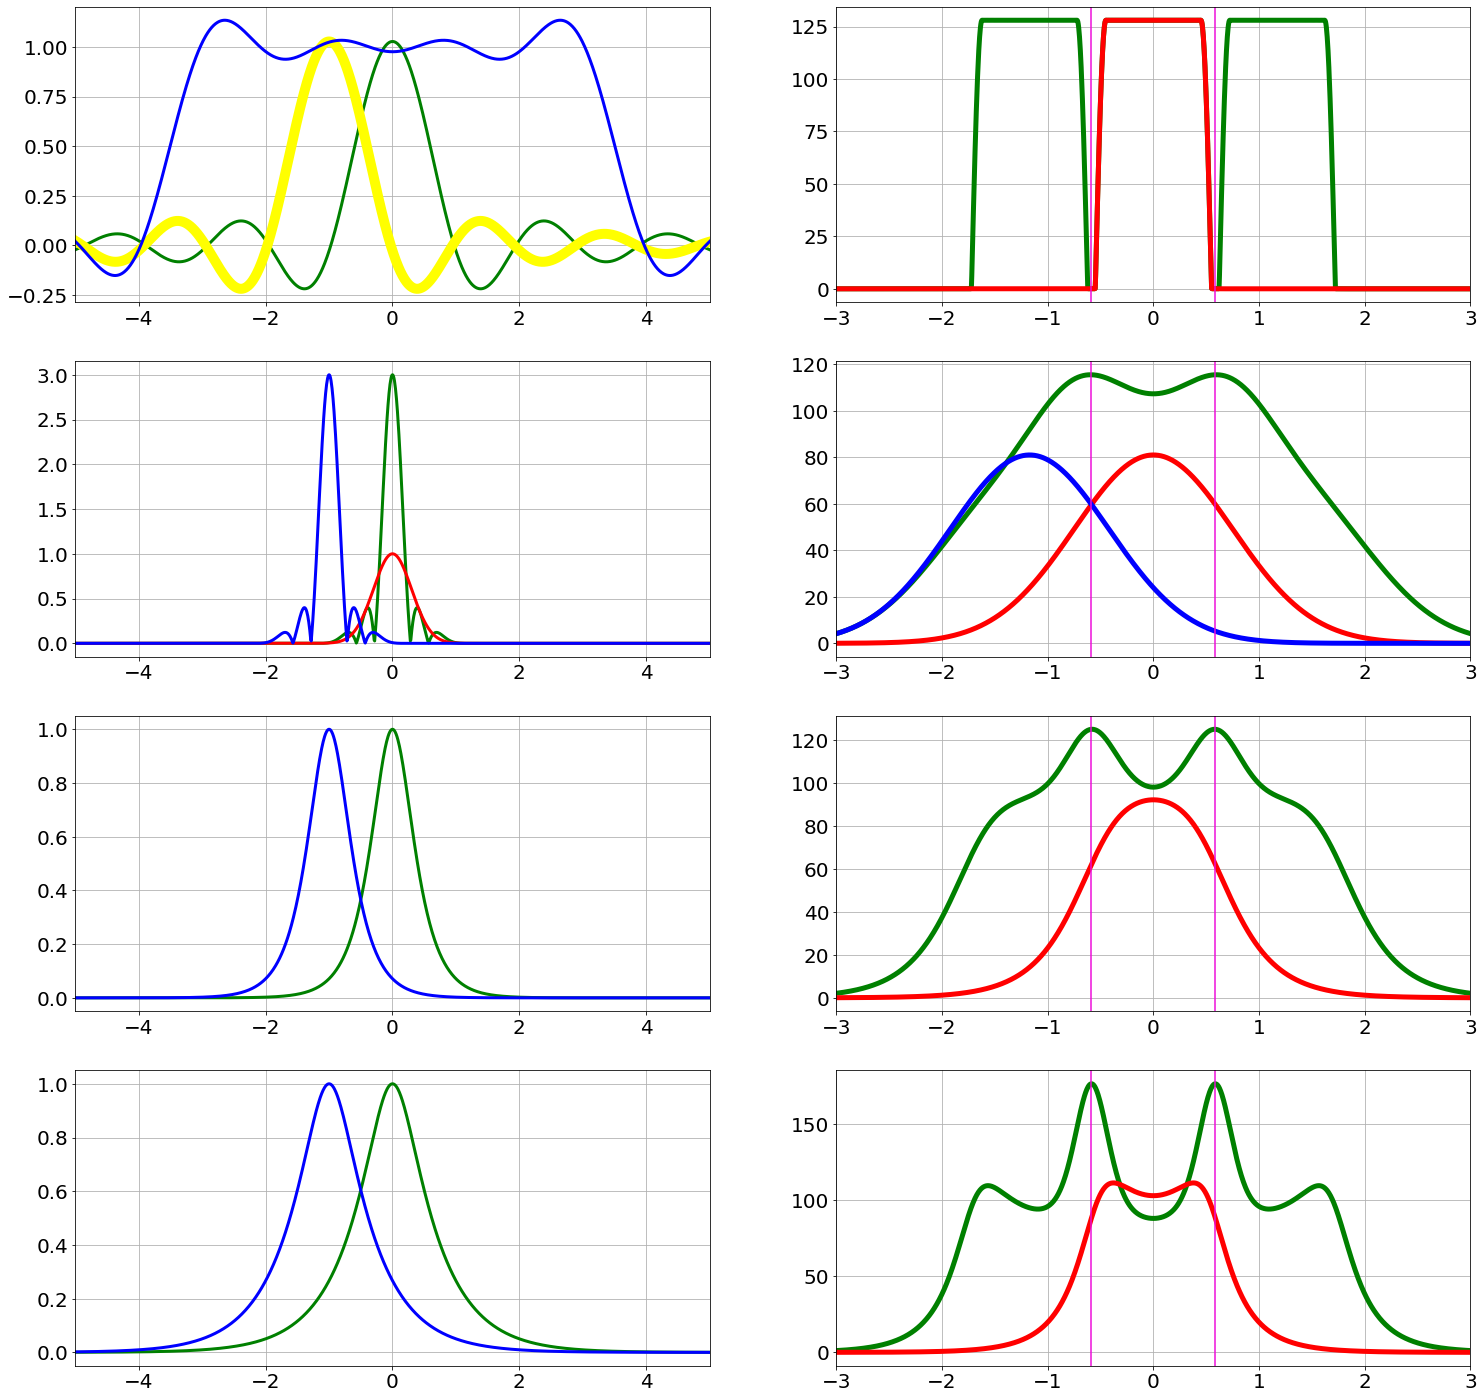

In [44]:
fig, axs = plt.subplots(4, 2, figsize=(25, 25))

t_scale_factor = 5
axs[0][0].plot(t, rrcos_time, linewidth=3, color='green')
axs[0][0].plot(t - t_symb, rrcos_time, linewidth=10, color='yellow')
axs[0][0].plot(t, rrcos_time_s1, linewidth=3, color='blue')
axs[0][0].set_xlim(-t_scale_factor * t_symb, t_scale_factor * t_symb)
# axs[0].plot(t, rrcos_time_new, linewidth=3, color='green')
# axs[0].set_xlim(-0.6 / t_symb, 0.6 / t_symb)

axs[1][0].plot(t, np.absolute(wdm_cgauss_time), linewidth=3, color='green')
axs[1][0].plot(t, np.absolute(cgauss_time), linewidth=3, color='red')
axs[1][0].plot(t - t_symb, np.absolute(wdm_cgauss_time), linewidth=3, color='blue')
# axs[1][0].plot(t, np.real(wdm_cgauss_time), linewidth=3, color='yellow')

axs[2][0].plot(t, np.absolute(cpulse_time), linewidth=3, color='green')
axs[2][0].plot(t - t_symb, np.absolute(cpulse_time), linewidth=3, color='blue')
# axs[2][0].plot(t, np.real(cpulse_time), linewidth=3, color='yellow')

axs[3][0].plot(t, np.absolute(vcpulse_time), linewidth=3, color='green')
# axs[3][0].plot(t, np.roll(np.absolute(add_side_signal(vcpulse_time, 10, int(t_symb / dt), side='left')), -int(30 * t_symb / dt)), linewidth=3, color='blue')

# axs[3][0].plot(t, np.absolute(vcpulse_time * np.conjugate(np.roll(vcpulse_time, -int(t_symb / dt)))), linewidth=3, color='blue')
axs[3][0].plot(t - t_symb, np.absolute(vcpulse_time), linewidth=3, color='blue')
# axs[3][0].plot(t, np.real(vcpulse_time), linewidth=3, color='yellow')


axs[1][0].set_xlim(-t_scale_factor * t_symb, t_scale_factor * t_symb)
axs[2][0].set_xlim(-t_scale_factor * t_symb, t_scale_factor * t_symb)
axs[3][0].set_xlim(-t_scale_factor * t_symb, t_scale_factor * t_symb)


f_scale_factor = 3.0
axs[0][1].plot(f, np.absolute(wdm_rrcos_f), linewidth=5, color='green')
axs[0][1].plot(f, np.absolute(rrcos_f), linewidth=5, color='red')
axs[0][1].set_xlim(-f_scale_factor / t_symb, f_scale_factor / t_symb)

axs[1][1].plot(f, np.absolute(wdm_cgauss_f), linewidth=5, color='green')
axs[1][1].plot(f, np.absolute(cgauss_f), linewidth=5, color='red')
axs[1][1].plot(f, np.absolute(cgauss_f_shift), linewidth=5, color='blue')
# axs[1][1].plot(f, np.absolute(get_outband_spectrum(f, cgauss_f, dw, side='left')), linewidth=5, color='xkcd:bright pink')

axs[2][1].plot(f, np.absolute(wdm_cpulse_f), linewidth=5, color='green')
axs[2][1].plot(f, np.absolute(cpulse_f), linewidth=5, color='red')
axs[3][1].plot(f, np.absolute(wdm_vcpulse_f), linewidth=5, color='green')
axs[3][1].plot(f, np.absolute(vcpulse_f), linewidth=5, color='red')
# axs[3][1].plot(f, np.imag(vcpulse_f), linewidth=1, color='blue')

axs[1][1].set_xlim(-f_scale_factor / t_symb, f_scale_factor / t_symb)
axs[2][1].set_xlim(-f_scale_factor / t_symb, f_scale_factor / t_symb)
axs[3][1].set_xlim(-f_scale_factor / t_symb, f_scale_factor / t_symb)


for k in range(4):
    axs[k][1].axvline(x = -dw / 2, color = 'xkcd:fuchsia', label = '-dw/2')
    axs[k][1].axvline(x = dw / 2, color = 'xkcd:fuchsia', label = 'dw/2')
    for l in range(2):
        axs[k][l].grid(True)


In [51]:
t0_list = [0.3]
chirp_list = [0.2, 1, 2, 3]
vcpulse_time_array = []
vcpulse_f_array = []
b = 0

for t0_cur in t0_list:
    for chirp_cur in chirp_list:
        pulse = varying_chirped_pulse(t, chirp_cur, t0_cur, b)
        vcpulse_time_array.append(pulse)
        vcpulse_f_array.append(sp.fft.fftshift(sp.fft.fft(pulse)))

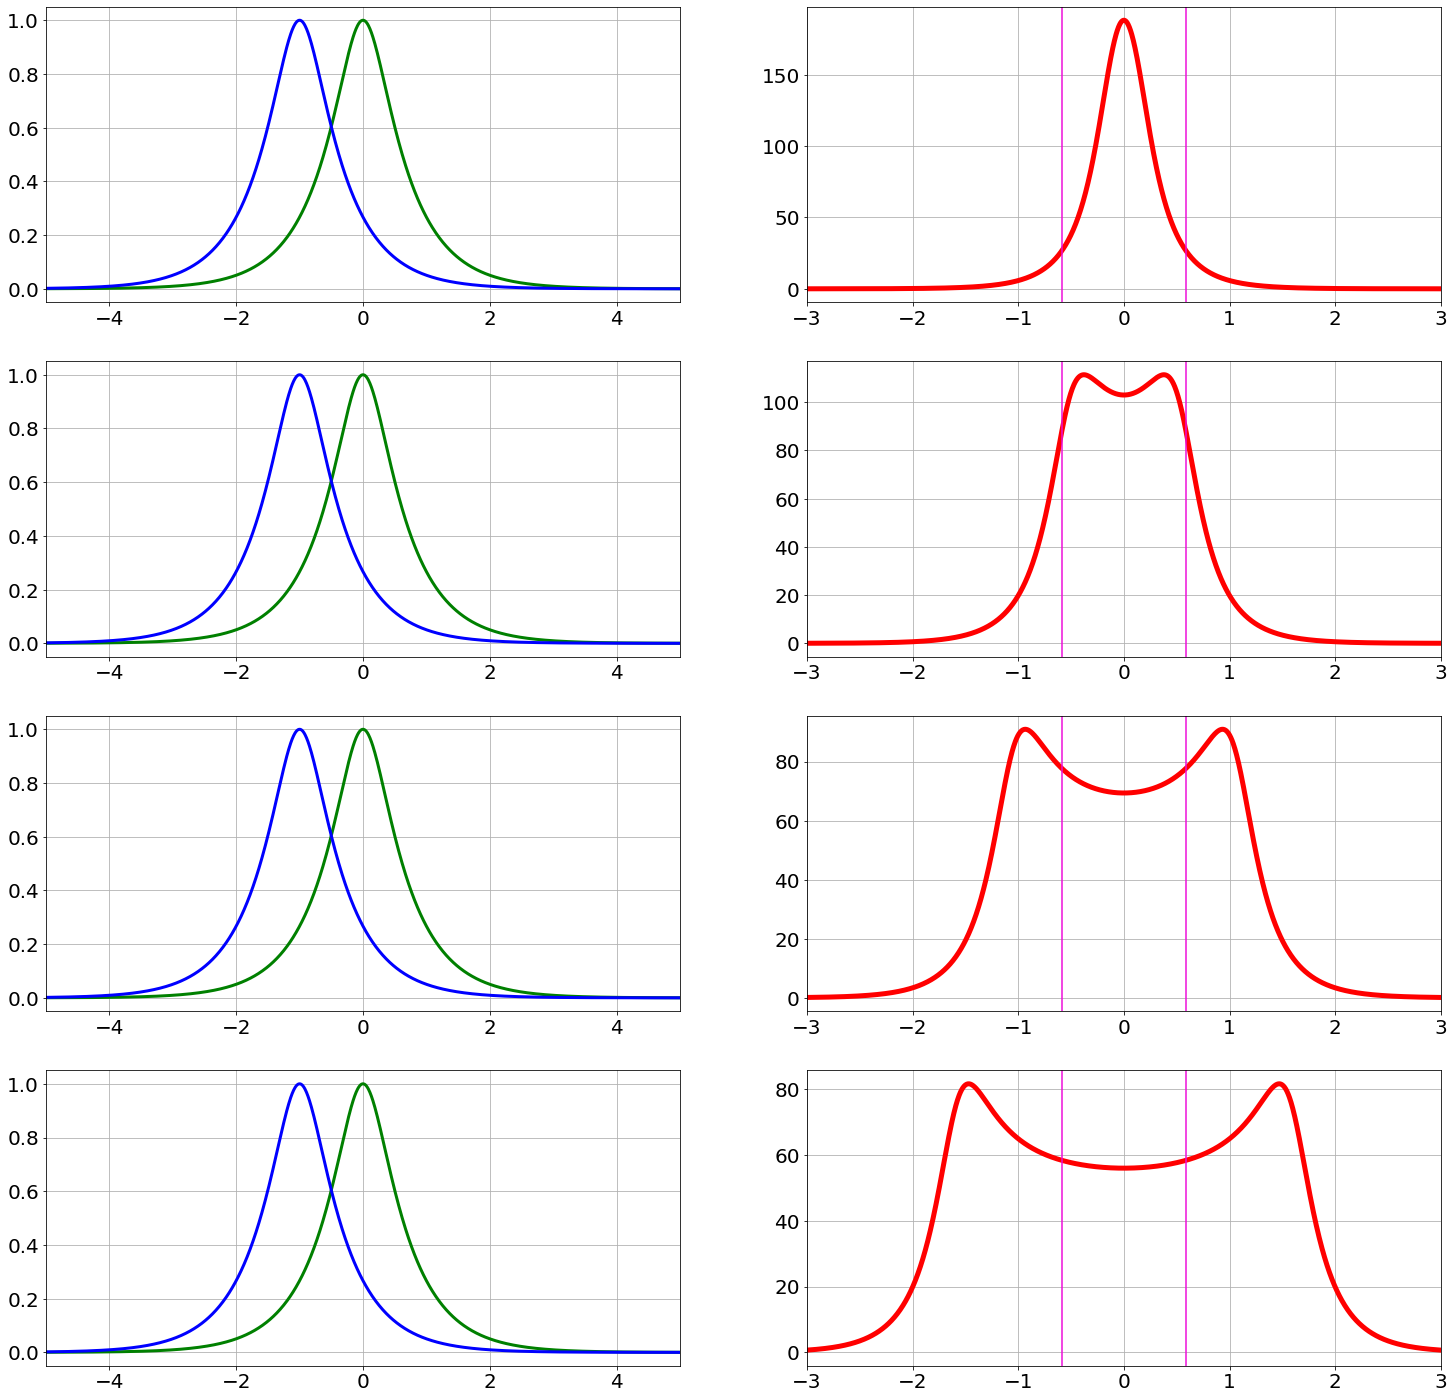

In [52]:
fig, axs = plt.subplots(4, 2, figsize=(25, 25))
t_scale_factor = 5

for k in range(4):

    axs[k][0].plot(t, np.absolute(vcpulse_time_array[k]), linewidth=3, color='green')
    axs[k][0].plot(t - t_symb, np.absolute(vcpulse_time_array[k]), linewidth=3, color='blue')
    axs[k][0].set_xlim(-t_scale_factor * t_symb, t_scale_factor * t_symb)

    axs[k][1].plot(f, np.absolute(vcpulse_f_array[k]), linewidth=5, color='red')
    axs[k][1].set_xlim(-f_scale_factor / t_symb, f_scale_factor / t_symb)



for k in range(4):
    axs[k][1].axvline(x = -dw / 2, color = 'xkcd:fuchsia', label = '-dw/2')
    axs[k][1].axvline(x = dw / 2, color = 'xkcd:fuchsia', label = 'dw/2')
    for l in range(2):
        axs[k][l].grid(True)

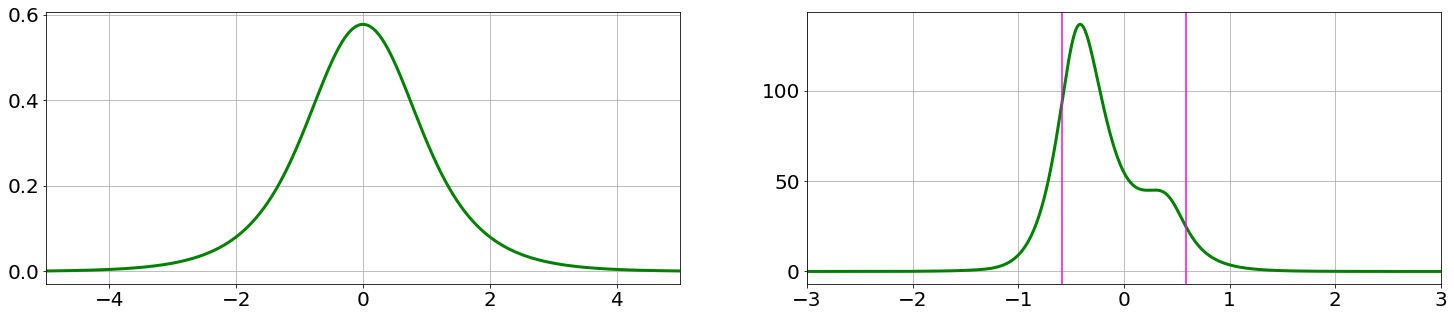

In [188]:
dw = 75. / 64.
t0 = 0.35
chirp = 1
b = 2
# vcpulse_time_search = varying_chirped_pulse(t, chirp, t0, b) + varying_chirped_pulse(-t, chirp, t0, b)
vcpulse_time_search = varying_chirped_pulse(t, chirp, t0, b)

vcpulse_f_search = fftshift(fft(vcpulse_time_search))

fig, axs = plt.subplots(1, 2, figsize=(25, 5))

t_scale_factor = 5.0
axs[0].plot(t, np.absolute(vcpulse_time_search), linewidth=3, color='green')
axs[0].set_xlim(-t_scale_factor * t_symb, t_scale_factor * t_symb)

f_scale_factor = 3.0
axs[1].plot(f, np.absolute(vcpulse_f_search), linewidth=3, color='green')
axs[1].set_xlim(-f_scale_factor / t_symb, f_scale_factor / t_symb)

axs[1].axvline(x = -dw / 2, color = 'xkcd:fuchsia', label = '-dw/2')
axs[1].axvline(x = dw / 2, color = 'xkcd:fuchsia', label = 'dw/2')

axs[0].grid(True)
axs[1].grid(True)

In [ ]:

# rcos_time = np.zeros(len(t))
rcos_spec = np.zeros(len(f))
for k in range(len(f)):
    rcos_spec[k] = rc_filter_freq_base(f[k], t_symb, roll_off)
#     rcos_time[k] = rc_filter(t[k], t_symb, roll_off)

start_time = datetime.now()
rrcos_time = ch.rrcosfilter_our(nt_span, roll_off, t_symb, 1 / dt)
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000
print("Signal generation took", execution_time, "ms")

start_time = datetime.now()
rrcos_time_new = rrcosfilter_new(nt_span, roll_off, t_symb, 1 / dt)
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000
print("Signal generation took", execution_time, "ms")



# rcos_time = ch.rrcosfilter_our(nt_span, roll_off, t_symb, 1 / dt)
#
# rrcosfilter_our(np_sequence, wdm['roll_off'], t_s, sample_freq)

In [ ]:
print(np.max(np.absolute(rrcos_time - rrcos_time_new * t_symb)))

In [ ]:
t = (np.arange(nt_span) - nt_span / 2.) * dt

all_pos = np.where(~(np.isclose(abs(t), 0.25 * t_symb / roll_off, atol=1e-16, rtol=1e-15) | np.isclose(t, 0., atol=1e-16, rtol=1e-15)))
# all_pos = np.where(~np.where(np.isclose(t, 0., atol=1e-16, rtol=1e-15)))
zero_pos = np.where(np.isclose(t, 0., atol=1e-16, rtol=1e-15))

print(all_pos)
print(np.shape(all_pos))
print(zero_pos, np.shape(zero_pos))

In [ ]:
fft_f = sp.fft.fftfreq(nt_span, d=dt)

In [ ]:
def rc_filter_freq_base(f, t_symb, beta):

    if abs(f) <= 0.5 * (1. - beta) / t_symb:
        return 1.0
    elif 0.5 * (1. - beta) / t_symb < abs(f) < 0.5 * (1. + beta) / t_symb:
        return 0.5 * (1 + np.cos(np.pi * t_symb / beta * (abs(f) - 0.5 * (1. - beta) / t_symb)))
    else:
        return 0

def rc_filter_base(t, t_symb, beta):

    one_over_ts = 1.0 / t_symb
    if np.isclose(beta, 0., atol=1e-16, rtol=1e-15):
        return one_over_ts * np.sinc(t * one_over_ts)

    if np.isclose(abs(t), 0.5 * t_symb / beta, atol=1e-16, rtol=1e-15):
        return 0.25 * np.pi * one_over_ts * np.sinc(0.5 / beta)
    else:
        return one_over_ts * np.sinc(t * one_over_ts) * np.cos(np.pi * beta * t * one_over_ts) / (1. - 4. * (beta * t * one_over_ts) ** 2)

def rrc_filter_base(t, t_symb, beta):

    one_over_ts = 1.0 / t_symb
    if np.isclose(t, 0., atol=1e-16, rtol=1e-15):
        return one_over_ts * (1. + beta * (4. / np.pi - 1))
    # elif beta != 0. and abs(t) == 0.25 * t_symb / beta:
    #     return beta * one_over_ts / np.sqrt(2) * ((1. + 2. / np.pi) * np.sin(0.25 * np.pi / beta) + (1. - 2. / np.pi) * np.cos(0.25 * np.pi / beta))
    elif beta != 0. and np.isclose(abs(t), 0.25 * t_symb / beta, atol=1e-16, rtol=1e-15):
        return beta * one_over_ts / np.sqrt(2) * ((1. + 2. / np.pi) * np.sin(0.25 * np.pi / beta) + (1. - 2. / np.pi) * np.cos(0.25 * np.pi / beta))
    else:
        return (np.sin(np.pi * (1. - beta) * t * one_over_ts) + 4. * beta * t * one_over_ts * np.cos(np.pi * (1. + beta) * t * one_over_ts)) / \
               (np.pi * t * (1. - (4. * beta * t * one_over_ts) ** 2))

def rrcosfilter_our(N, alpha, Ts, Fs):

    dt = 1. / float(Fs)
    t = (np.arange(N) - N / 2.) * dt
    rrc = np.zeros(N, dtype=np.float)

    for k in range(N):
        # try:
        rrc[k] = rrc_filter_base(t[k], Ts, alpha)
        # except Exception as e:
        #     print('t_k = ', t[k], e)
        #     rrc[k] = rrc_filter_base(t[k], Ts, alpha)


    return rrc


def rrcosfilter_new(nt, beta, t_symb, sample_rate):

    one_over_ts = 1.0 / t_symb
    dt = 1. / float(sample_rate)
    t = (np.arange(nt) - nt / 2.) * dt
    rrc = np.zeros(nt, dtype=np.float)

    # found ranges for conditions
    zero_pos = np.where(np.isclose(t, 0., atol=1e-16, rtol=1e-15))
    if beta != 0:
        nodes_pos = np.where(np.isclose(abs(t), 0.25 * t_symb / beta, atol=1e-16, rtol=1e-15))
        all_pos = np.where(~(np.isclose(abs(t), 0.25 * t_symb / beta, atol=1e-16, rtol=1e-15) | np.isclose(t, 0., atol=1e-16, rtol=1e-15)))

        # if np.shape(nodes_pos)[1] != 0:
        #     nodes_values = np.zeros(len(t[nodes_pos]), dtype=float) * beta * one_over_ts / np.sqrt(2) * \
        #                    ((1. + 2. / np.pi) * np.sin(0.25 * np.pi / beta) + (1. - 2. / np.pi) * np.cos(0.25 * np.pi / beta))
        #     rrc[nodes_pos] = nodes_values

        # all_values = (np.sin(np.pi * (1. - beta) * t[all_pos] * one_over_ts) +
        #               4. * beta * t[all_pos] * one_over_ts * np.cos(np.pi * (1. + beta) * t[all_pos] * one_over_ts)) / \
        #              (np.pi * t[all_pos] * (1. - np.power(4. * beta * t[all_pos] * one_over_ts, 2)))
        # rrc[all_pos] = all_values

    else:
        all_pos = np.where(~np.isclose(t, 0., atol=1e-16, rtol=1e-15))


    if beta != 0 and np.shape(nodes_pos)[1] != 0:
        print('dindon')
        nodes_values = np.ones(len(t[nodes_pos]), dtype=float) * beta * one_over_ts / np.sqrt(2) * \
                       ((1. + 2. / np.pi) * np.sin(0.25 * np.pi / beta) + (1. - 2. / np.pi) * np.cos(0.25 * np.pi / beta))
        rrc[nodes_pos] = nodes_values

    if np.shape(zero_pos)[1] != 0:
        rrc[zero_pos] = one_over_ts * (1. + beta * (4. / np.pi - 1))

    all_values = (np.sin(np.pi * (1. - beta) * t[all_pos] * one_over_ts) +
                  4. * beta * t[all_pos] * one_over_ts * np.cos(np.pi * (1. + beta) * t[all_pos] * one_over_ts)) / \
                 (np.pi * t[all_pos] * (1. - np.power(4. * beta * t[all_pos] * one_over_ts, 2)))
    rrc[all_pos] = all_values



    return rrc

In [ ]:
spec = fftshift(fft(rrcos_time))
print(np.max(np.imag(spec)))
spec_test = np.real(spec) + 1j * np.imag(spec)
print(np.max(np.absolute(spec) - np.real(spec)))

In [ ]:
points_sequence = np.zeros(wdm['upsampling'] * 30, dtype='complex')
points_sequence[::wdm['upsampling']] = points_x[:30]
ps_spectrum = sp.fft.fftshift(sp.fft.fft(points_sequence))

f_coef = 10.0
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(np.absolute(ps_spectrum), linewidth=1, color='green')
# axs[0].plot(freq, np.absolute(ft_init_filter), linewidth=8, color='blue')
# axs[0].plot(freq_cut, np.absolute(init_cut_spectrum), linewidth=2, color='green')
# axs[0].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
axs[0].grid(True)

# axs[1].plot(freq, np.absolute(spectrum_add_zero_sides(init_cut_spectrum, ft_filter_size) - ft_init_filter), linewidth=7, color='red')
# axs[1].plot(fft_f2, np.absolute(spec2), linewidth=3, color='green')
# axs[1].plot(fft_f2, np.absolute(spec_ups), linewidth=3, color='blue')
# axs[1].set_yscale('log')
# axs[1].set_xlim(-0.6 / t_symb, 0.6 / t_symb)
# axs[1].set_xlim(-f_coef * wdm['symb_freq'], f_coef * wdm['symb_freq'])
# axs[1].grid(True)



In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(15, 30))
axs[0].plot(f, np.absolute(spec_test) * dt , linewidth=7, color='green')
axs[0].plot(f, np.real(spec) * dt, linewidth=1, color='yellow')
# axs[0].plot(f, np.imag(fftshift(fft(rcos_time))) * dt / t_symb, linewidth=4, color='yellow')
axs[0].plot(f, np.absolute(rcos_spec), linewidth=3, color='red')
# axs[0].plot(w, np.absolute(ch.cut_spectrum(spectrum, f, wdm['channel_spacing'])), linewidth=3, color='green')
# axs[0].set_xlim(-0.1, 0.1)
# axs[0].set_xlim(-1, 1)
axs[0].set_xlim(-0.6 / t_symb, 0.6 / t_symb)
axs[0].grid(True)

# axs[1].plot(f, np.absolute(rcos_spec - fftshift(fft(rcos_time)) * dt / t_symb), linewidth=5, color='red')
# axs[1].set_yscale('log')
axs[1].set_xlim(-0.6 / t_symb, 0.6 / t_symb)
axs[1].grid(True)

# axs[2].plot(t, ifftshift(ifft(rcos_spec)), linewidth=3, color='blue')
axs[2].plot(t, np.absolute(rcos_time - rcos_time_new * t_symb), linewidth=3, color='green')
# axs[2].plot(t, rcos_time, linewidth=3, color='green')
# axs[1].plot(w, np.real(fftshift(fft(rcos_spec))), linewidth=3, color='red')
axs[2].set_yscale('log')
axs[2].grid(True)
# axs[1].set_xlim(-t_symb * 2, t_symb * 2)

axs[3].plot(t, np.absolute(ifft(ifftshift(rcos_spec)) - rcos_time), linewidth=3, color='blue')
axs[3].set_yscale('log')
axs[3].grid(True)

Benchmark

In [ ]:
# test signal generation
dt = 1. / wdm['sample_freq']
print(p_ave_y_dbm, p_ave_y)
print(wdm['p_ave_dbm'], wdm['p_ave'] / 2)
signal_x, signal_y = ch.generate_wdm_optimise(wdm, points_x, points_y, ft_filter_values * 1000)
# p_ave_filt = np.mean(np.power(np.absolute(ft_filter_values), 2))
# e_filt = np.sum(np.power(np.absolute(ft_filter_values), 2)) * dt

# print('e/p:', e_filt, p_ave_filt)
# print(sg.get_average_power(ft_filter_values * np.sqrt(2. / p_ave_filt), dt))
# print(dt)

# print(sg.get_energy(signal_x, dt), sg.get_energy(signal_y, dt))
print('p:', sg.get_average_power(signal_x, dt), sg.get_average_power(signal_y, dt))

p_ave_calc = np.mean(np.power(np.absolute(signal_x), 2))
print('p_ave_calc', p_ave_calc)
print(sg.mw_to_dbm(p_ave_calc * 1000 * 2))
print(sg.dbm_to_mw(4) / 1000 / 2)

print(sg.mw_to_dbm(sg.dbm_to_mw(4)))

In [89]:
print(sg.dbm_to_mw(4) / 1000 / 2 * 7)

0.008791602510283531


In [93]:
reload(sg)
reload(wf)
reload(ch)

<module 'channel_model' from '/home/esf0/PycharmProjects/nn_essential/channel_model.py'>

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame()

n_channels_list = [1, 7, 15]
# n_channels_list = [7]
# p_ave_dbm_list = np.arange(61) * 0.5 - 20
p_ave_dbm_list = np.arange(21) * 1 - 10
# p_ave_dbm_list = [4]
n_span_list = [6, 9, 12, 15, 18, 20, 21, 24, 25]
# n_span_list = [12]

for n_channels in n_channels_list:
    for p_ave_dbm in p_ave_dbm_list:
        for n_span in n_span_list:
            wdm_full = ch.create_wdm_parameters(n_channels=n_channels, p_ave_dbm=p_ave_dbm, n_symbols=2 ** 16, m_order=16, roll_off=0.1, upsampling=16,
                                           downsampling_rate=1, symb_freq=34e9, channel_spacing=75e9, n_polarisations=2)

            channel_full = ch.create_channel_parameters(n_spans=n_span,
                                                   z_span=80,
                                                   alpha_db=0.2,
                                                   gamma=1.2,
                                                   noise_figure_db=4.5,
                                                   dispersion_parameter=16.8,
                                                   dz=1)

            test_result_full = ch.full_line_model_wdm(channel_full, wdm_full)

            test_result_full['wdm'] = wdm_full
            test_result_full['channel'] = channel_full

            test_result_full['n_channels'] = n_channels
            test_result_full['p_ave_dbm'] = p_ave_dbm
            test_result_full['z_km'] = n_span * 80

            df = df.append(test_result_full, ignore_index=True)

df.to_pickle(r'data/benchmark/benchmark_1.pkl')

# print(test_result_full.keys())

Signal generation took 411.25899999999996 ms
Average signal power (x / y): 0.0000500 / 0.0000500 (has to be close to 0.0000500)
Matched filter took 230.119 ms
Matched filter took 226.009 ms
BER (x / y): (0.023792266845703125, 6237) (0.023563385009765625, 6177)
Q^2-factor (x / y): 1.9810601039667355 1.9851591281686551
Function [full_line_model_wdm] execution took 11857.063999999998 ms
Signal generation took 384.051 ms
Average signal power (x / y): 0.0000500 / 0.0000500 (has to be close to 0.0000500)
Matched filter took 231.856 ms
Matched filter took 227.894 ms
BER (x / y): (0.047454833984375, 12440) (0.048084259033203125, 12605)
Q^2-factor (x / y): 1.6700490067615223 1.663719397295052
Function [full_line_model_wdm] execution took 12171.27 ms
Signal generation took 381.859 ms
Average signal power (x / y): 0.0000500 / 0.0000500 (has to be close to 0.0000500)
Matched filter took 231.643 ms
Matched filter took 227.596 ms
BER (x / y): (0.07098388671875, 18608) (0.0709381103515625, 18596)
Q^2

In [1]:
ind = 0
points_x_shifted_f = test_result_full['points_x_shifted'][ind]
points_y_shifted_f = test_result_full['points_y_shifted'][ind]
points_x_f = test_result_full['points_x_orig'][ind]
points_y_f = test_result_full['points_y_orig'][ind]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(points_x_shifted_f.real, points_x_shifted_f.imag, s=12, c='b', marker='x')
axs[0].scatter(points_x_f.real, points_x_f.imag, s=6, c='r', marker='.')
axs[0].grid(True)

axs[1].scatter(points_y_shifted_f.real, points_y_shifted_f.imag, s=12, c='b', marker='x')
axs[1].scatter(points_y_f.real, points_y_f.imag, s=6, c='r', marker='.')
axs[1].grid(True)

NameError: name 'test_result_full' is not defined

In [2]:
print(df)

NameError: name 'df' is not defined